# NASA Turbofan Engine RUL - Comprehensive Exploratory Data Analysis

In [18]:
!pip install umap-learn shap statsmodels

  Using cached numba-0.61.2-cp312-cp312-win_amd64.whl.metadata (2.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached llvmlite-0.44.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/90.1 kB ? eta -:--:--
   ---------------------------------------- 90.1/90.1 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   --------------------------------------  542.7/545.3 kB 17.2 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.6/9.6 MB 13.3 MB/s eta 0:00:01
   ----- ---------------------------------- 1.4/9.6 MB 14.5 MB/s eta 0:00:01
   --------- ------------------------------ 2.2/9.6 MB 15.3 MB/s eta 0:00:01
   ------------- --------------------------

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

  Using cached numpy-2.3.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
  Using cached scikit_learn-1.7.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/111.9 kB ? eta -:--:--
     -------------------------------------- 111.9/111.9 kB 6.8 MB/s eta 0:00:00
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set up paths
DATA_PATH = Path('../CMAPSSData')
REPORTS_PATH = Path('../reports')
REPORTS_PATH.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Data path: {DATA_PATH}")
print(f"Reports path: {REPORTS_PATH}")

Libraries imported successfully!
Data path: ..\CMAPSSData
Reports path: ..\reports


In [3]:
# Define column names based on C-MAPSS dataset documentation
COLUMN_NAMES = [
    'unit_id', 'time_cycles', 'setting1', 'setting2', 'setting3'
] + [f'sensor_{i}' for i in range(1, 22)]

# Sensor descriptions for better interpretation
SENSOR_DESCRIPTIONS = {
    'sensor_1': 'T2 - Total temperature at fan inlet (°R)',
    'sensor_2': 'T24 - Total temperature at LPC outlet (°R)', 
    'sensor_3': 'T30 - Total temperature at HPC outlet (°R)',
    'sensor_4': 'T50 - Total temperature at LPT outlet (°R)',
    'sensor_5': 'P2 - Pressure at fan inlet (psia)',
    'sensor_6': 'P15 - Total pressure in bypass-duct (psia)',
    'sensor_7': 'P30 - Total pressure at HPC outlet (psia)',
    'sensor_8': 'Nf - Physical fan speed (rpm)',
    'sensor_9': 'Nc - Physical core speed (rpm)',
    'sensor_10': 'epr - Engine pressure ratio (P50/P2)',
    'sensor_11': 'Ps30 - Static pressure at HPC outlet (psia)',
    'sensor_12': 'phi - Ratio of fuel flow to Ps30 (pps/psia)',
    'sensor_13': 'NRf - Corrected fan speed (rpm)',
    'sensor_14': 'NRc - Corrected core speed (rpm)',
    'sensor_15': 'BPR - Bypass Ratio',
    'sensor_16': 'farB - Burner fuel-air ratio',
    'sensor_17': 'htBleed - Bleed Enthalpy',
    'sensor_18': 'Nf_dmd - Demanded fan speed (rpm)',
    'sensor_19': 'PCNfR_dmd - Demanded corrected fan speed (rpm)',
    'sensor_20': 'W31 - HPT coolant bleed (lbm/s)',
    'sensor_21': 'W32 - LPT coolant bleed (lbm/s)'
}

def load_dataset(dataset_name):
    """Load training, test, and RUL data for a specific dataset"""
    train_file = DATA_PATH / f'train_{dataset_name}.txt'
    test_file = DATA_PATH / f'test_{dataset_name}.txt'
    rul_file = DATA_PATH / f'RUL_{dataset_name}.txt'
    
    # Load training data
    train_df = pd.read_csv(train_file, sep=' ', header=None, names=COLUMN_NAMES)
    train_df = train_df.dropna(axis=1)  # Remove any empty columns
    
    # Load test data
    test_df = pd.read_csv(test_file, sep=' ', header=None, names=COLUMN_NAMES)
    test_df = test_df.dropna(axis=1)
    
    # Load RUL data
    rul_df = pd.read_csv(rul_file, header=None, names=['RUL'])
    
    return train_df, test_df, rul_df

def calculate_rul(df):
    """Calculate RUL for training data"""
    df_rul = df.copy()
    # Calculate max cycles for each unit
    max_cycles = df_rul.groupby('unit_id')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycles']
    
    # Merge and calculate RUL
    df_rul = df_rul.merge(max_cycles, on='unit_id')
    df_rul['RUL'] = df_rul['max_cycles'] - df_rul['time_cycles']
    
    return df_rul

print("Data loading functions defined!")


Data loading functions defined!


In [4]:
# Load All Datasets
datasets = {}
dataset_names = ['FD001', 'FD002', 'FD003', 'FD004']

print("Loading all datasets...")
for name in dataset_names:
    print(f"Loading {name}...")
    train_df, test_df, rul_df = load_dataset(name)
    
    # Calculate RUL for training data
    train_df_with_rul = calculate_rul(train_df)
    
    datasets[name] = {
        'train': train_df_with_rul,
        'test': test_df,
        'rul': rul_df,
        'train_raw': train_df
    }
    
    print(f"{name} - Train: {train_df.shape}, Test: {test_df.shape}, RUL: {rul_df.shape}")

print("\nAll datasets loaded successfully!")


Loading all datasets...
Loading FD001...
FD001 - Train: (20631, 24), Test: (13096, 24), RUL: (100, 1)
Loading FD002...
FD002 - Train: (53759, 24), Test: (33991, 24), RUL: (259, 1)
Loading FD003...
FD003 - Train: (24720, 24), Test: (16596, 24), RUL: (100, 1)
Loading FD004...
FD004 - Train: (61249, 24), Test: (41214, 24), RUL: (248, 1)

All datasets loaded successfully!


In [3]:
# Dataset Overview and Basic Statistics
print("=== DATASET OVERVIEW ===\n")

dataset_info = {
    'FD001': {'conditions': 1, 'fault_modes': 1, 'description': 'Sea Level, HPC Degradation'},
    'FD002': {'conditions': 6, 'fault_modes': 1, 'description': 'Six Conditions, HPC Degradation'},
    'FD003': {'conditions': 1, 'fault_modes': 2, 'description': 'Sea Level, HPC + Fan Degradation'},
    'FD004': {'conditions': 6, 'fault_modes': 2, 'description': 'Six Conditions, HPC + Fan Degradation'}
}

summary_stats = []
for name in dataset_names:
    train_df = datasets[name]['train']
    test_df = datasets[name]['test']
    
    stats_dict = {
        'Dataset': name,
        'Description': dataset_info[name]['description'],
        'Train_Engines': train_df['unit_id'].nunique(),
        'Test_Engines': test_df['unit_id'].nunique(),
        'Train_Cycles': len(train_df),
        'Test_Cycles': len(test_df),
        'Avg_Train_Life': train_df.groupby('unit_id')['time_cycles'].max().mean(),
        'Max_Train_Life': train_df.groupby('unit_id')['time_cycles'].max().max(),
        'Min_Train_Life': train_df.groupby('unit_id')['time_cycles'].max().min(),
        'Conditions': dataset_info[name]['conditions'],
        'Fault_Modes': dataset_info[name]['fault_modes']
    }
    summary_stats.append(stats_dict)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))



KeyboardInterrupt: 

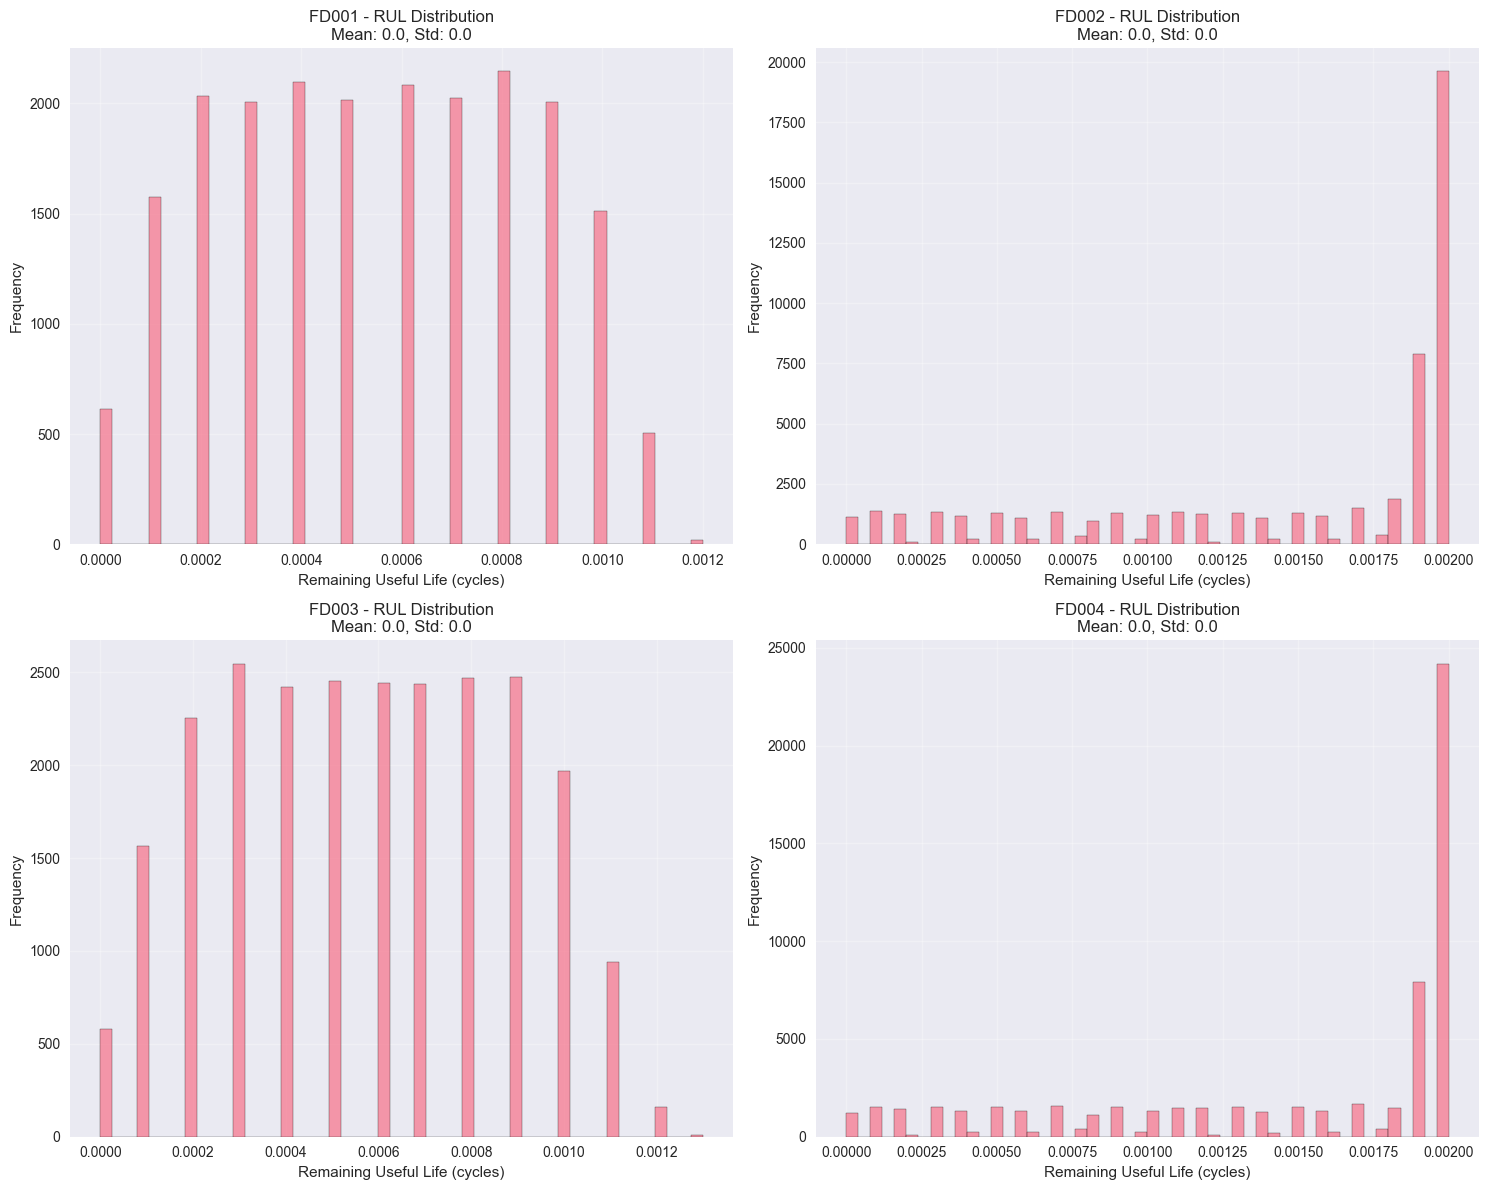

In [5]:
# RUL Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, name in enumerate(dataset_names):
    train_df = datasets[name]['train']
    rul_values = train_df['RUL'].values
    
    axes[i].hist(rul_values, bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{name} - RUL Distribution\nMean: {rul_values.mean():.1f}, Std: {rul_values.std():.1f}')
    axes[i].set_xlabel('Remaining Useful Life (cycles)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'rul_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


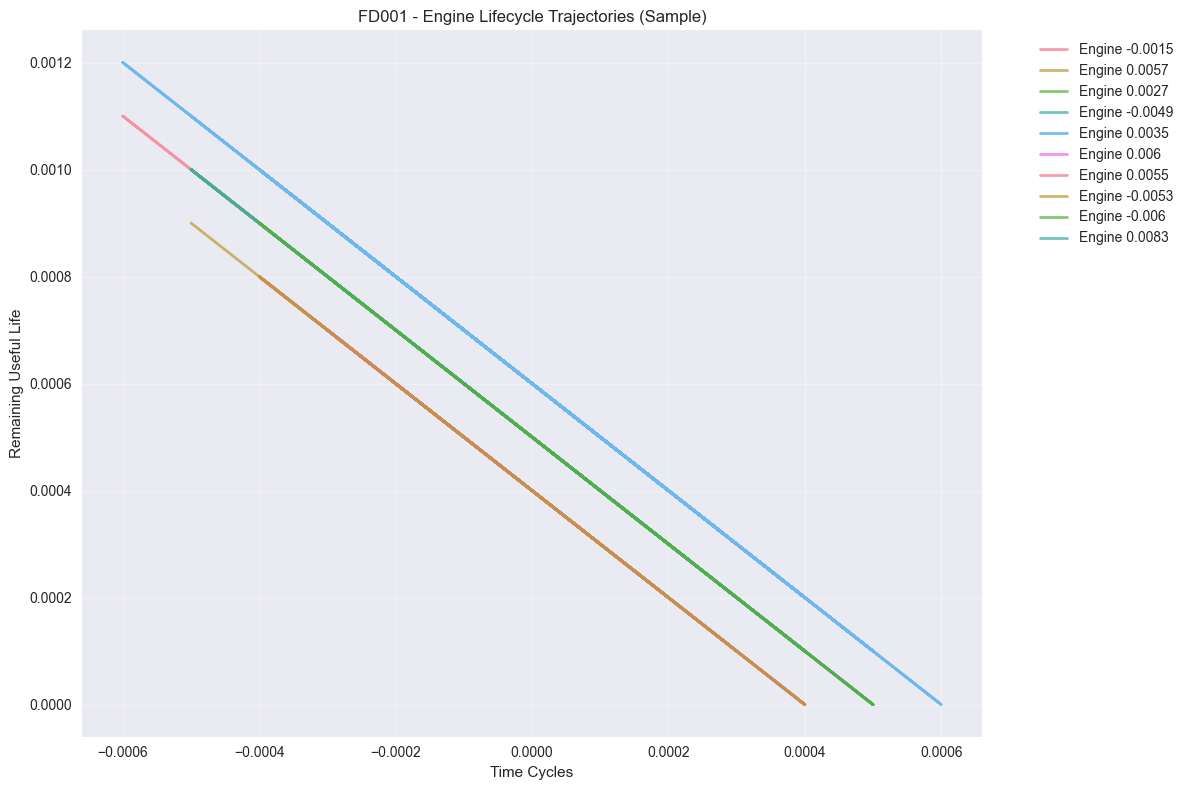

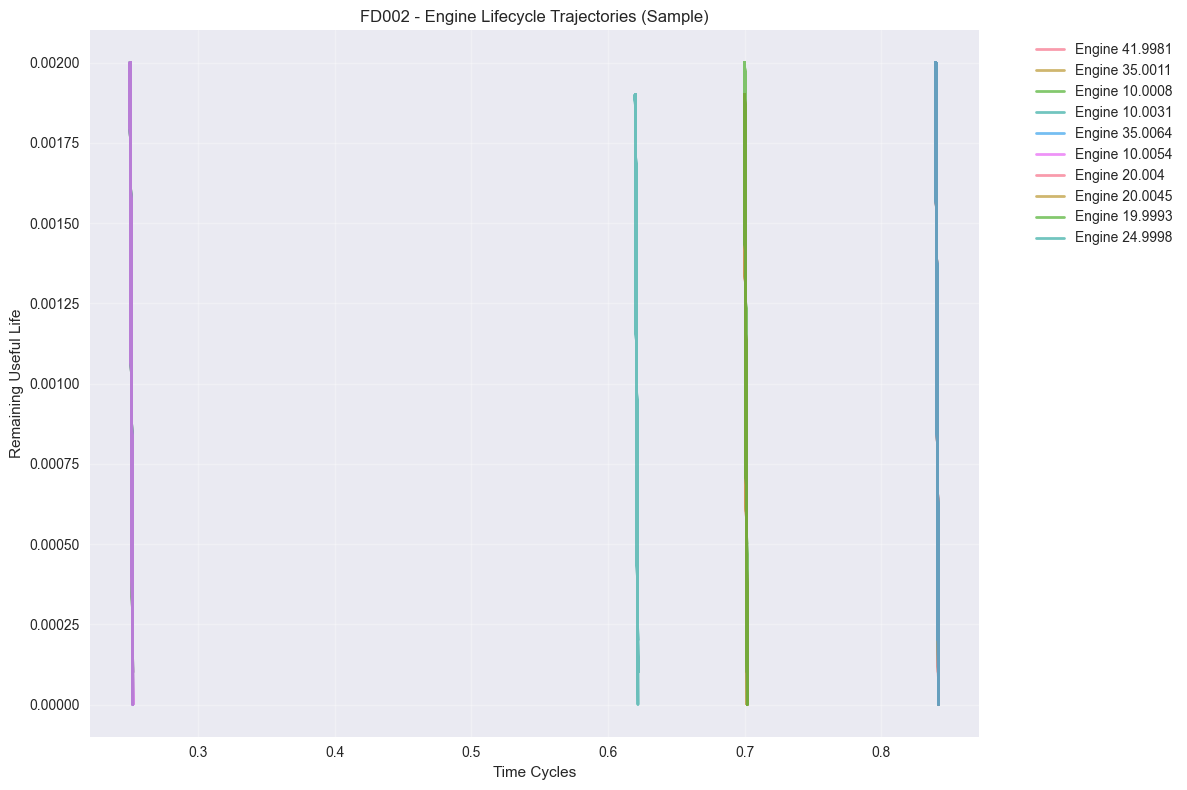

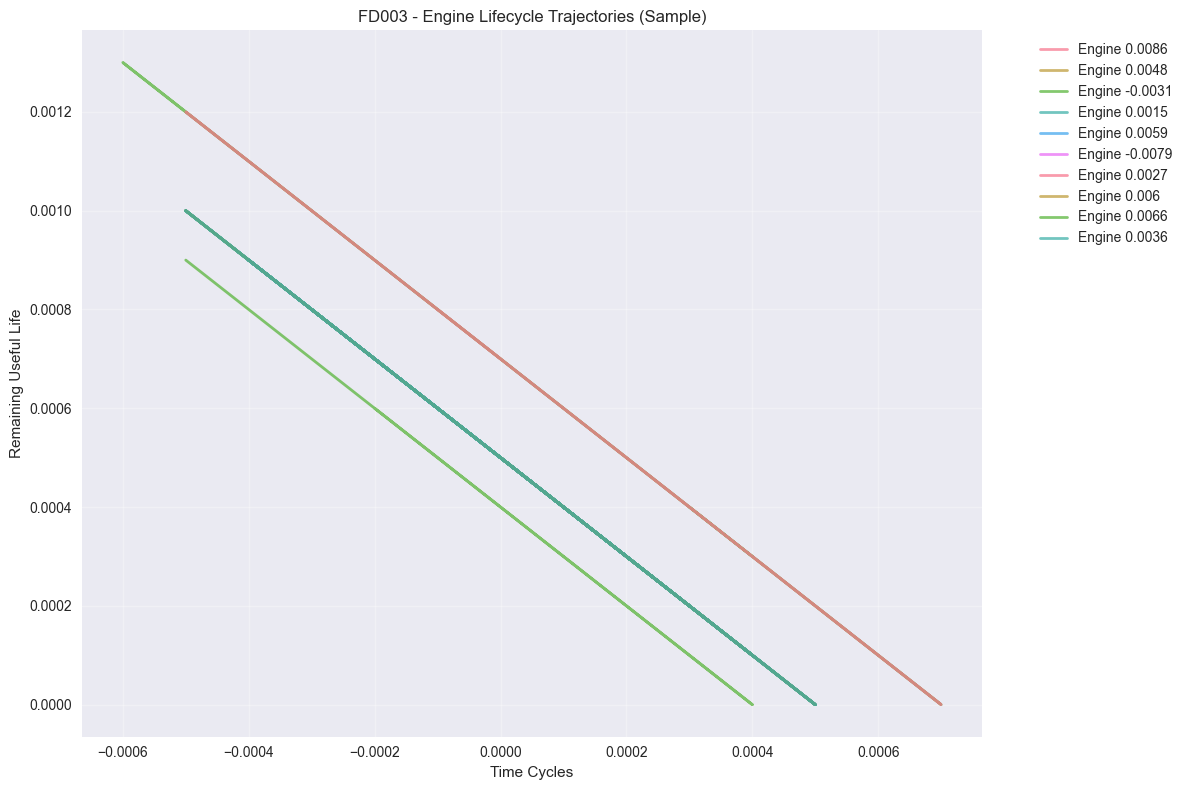

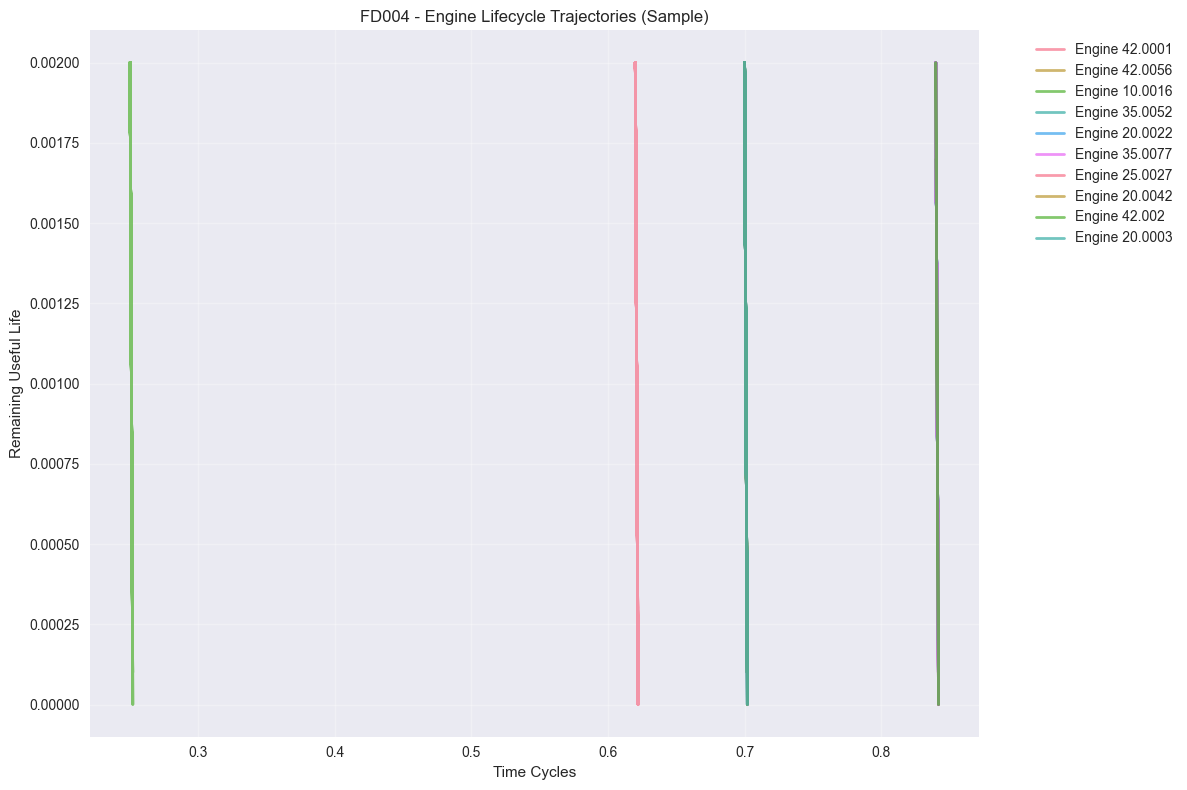

In [6]:
# Engine Lifecycle Analysis
def plot_engine_lifecycles(dataset_name, max_engines=10):
    """Plot lifecycle trajectories for sample engines"""
    train_df = datasets[dataset_name]['train']
    
    # Select random engines for visualization
    unique_engines = train_df['unit_id'].unique()
    sample_engines = np.random.choice(unique_engines, min(max_engines, len(unique_engines)), replace=False)
    
    plt.figure(figsize=(12, 8))
    
    for engine_id in sample_engines:
        engine_data = train_df[train_df['unit_id'] == engine_id]
        plt.plot(engine_data['time_cycles'], engine_data['RUL'], 
                label=f'Engine {engine_id}', alpha=0.7, linewidth=2)
    
    plt.title(f'{dataset_name} - Engine Lifecycle Trajectories (Sample)')
    plt.xlabel('Time Cycles')
    plt.ylabel('Remaining Useful Life')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_lifecycles.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot for each dataset
for name in dataset_names:
    plot_engine_lifecycles(name)


=== OPERATIONAL SETTINGS ANALYSIS ===



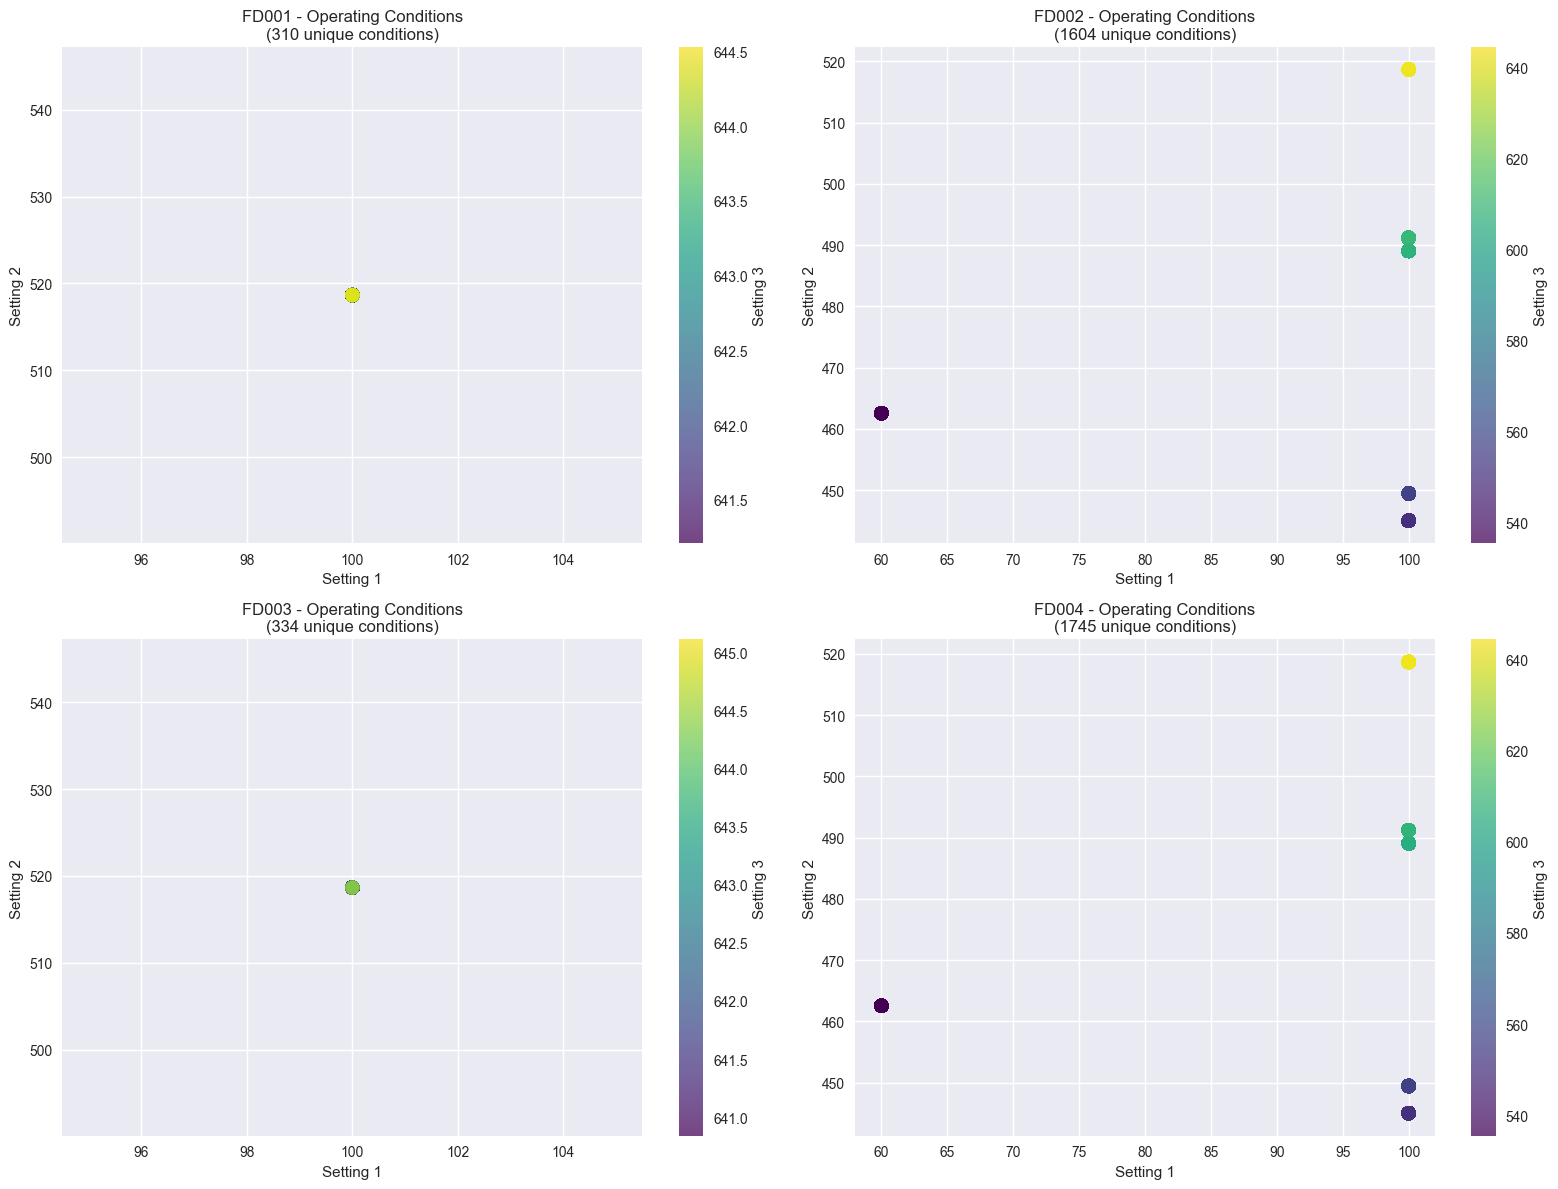

In [7]:
# Operational Settings Analysis
print("=== OPERATIONAL SETTINGS ANALYSIS ===\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, name in enumerate(dataset_names):
    train_df = datasets[name]['train']

    # Create subplot for operational settings
    ax = axes[i]

    # Plot 3D scatter of operational settings
    settings_df = train_df[['setting1', 'setting2', 'setting3']].drop_duplicates()

    if len(settings_df) > 1:  # Multiple operating conditions
        scatter = ax.scatter(settings_df['setting1'], settings_df['setting2'],
                           c=settings_df['setting3'], cmap='viridis', s=100, alpha=0.7)
        ax.set_xlabel('Setting 1')
        ax.set_ylabel('Setting 2')
        ax.set_title(f'{name} - Operating Conditions\n({len(settings_df)} unique conditions)')
        plt.colorbar(scatter, ax=ax, label='Setting 3')
    else:  # Single operating condition
        ax.text(0.5, 0.5, f'{name}\nSingle Operating Condition\nSetting1: {settings_df.iloc[0]["setting1"]:.3f}\nSetting2: {settings_df.iloc[0]["setting2"]:.3f}\nSetting3: {settings_df.iloc[0]["setting3"]:.3f}',
                ha='center', va='center', transform=ax.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax.set_title(f'{name} - Operating Conditions')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig(REPORTS_PATH / 'operational_settings.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Sensor Data Overview and Constant Sensors Detection
print("=== SENSOR DATA ANALYSIS ===\n")

def analyze_sensor_variance(dataset_name):
    """Analyze sensor variance to identify constant/low-variance sensors"""
    train_df = datasets[dataset_name]['train']
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]

    sensor_stats = {}
    for sensor in sensor_cols:
        sensor_stats[sensor] = {
            'mean': train_df[sensor].mean(),
            'std': train_df[sensor].std(),
            'min': train_df[sensor].min(),
            'max': train_df[sensor].max(),
            'range': train_df[sensor].max() - train_df[sensor].min(),
            'cv': train_df[sensor].std() / train_df[sensor].mean() if train_df[sensor].mean() != 0 else 0
        }

    return pd.DataFrame(sensor_stats).T

# Analyze sensor variance for all datasets
sensor_analysis = {}
for name in dataset_names:
    sensor_analysis[name] = analyze_sensor_variance(name)
    print(f"\n{name} - Sensors with low variance (CV < 0.01):")
    low_var_sensors = sensor_analysis[name][sensor_analysis[name]['cv'] < 0.01]
    if len(low_var_sensors) > 0:
        print(low_var_sensors[['mean', 'std', 'cv']].round(4))
    else:
        print("No low variance sensors found")


=== SENSOR DATA ANALYSIS ===


FD001 - Sensors with low variance (CV < 0.01):
                mean      std      cv
sensor_1   1590.5231   6.1311  0.0039
sensor_2   1408.9338   9.0006  0.0064
sensor_3     14.6200   0.0000  0.0000
sensor_4     21.6098   0.0014  0.0001
sensor_5    553.3677   0.8851  0.0016
sensor_6   2388.0967   0.0710  0.0000
sensor_7   9065.2429  22.0829  0.0024
sensor_8      1.3000   0.0000  0.0000
sensor_9     47.5412   0.2671  0.0056
sensor_10   521.4135   0.7376  0.0014
sensor_11  2388.0962   0.0719  0.0000
sensor_12  8143.7527  19.0762  0.0023
sensor_13     8.4421   0.0375  0.0044
sensor_14     0.0300   0.0000  0.0000
sensor_15   393.2107   1.5488  0.0039
sensor_16  2388.0000   0.0000  0.0000
sensor_17   100.0000   0.0000  0.0000
sensor_18    38.8163   0.1807  0.0047
sensor_19    23.2897   0.1083  0.0046

FD002 - Sensors with low variance (CV < 0.01):
No low variance sensors found

FD003 - Sensors with low variance (CV < 0.01):
                mean      std      c

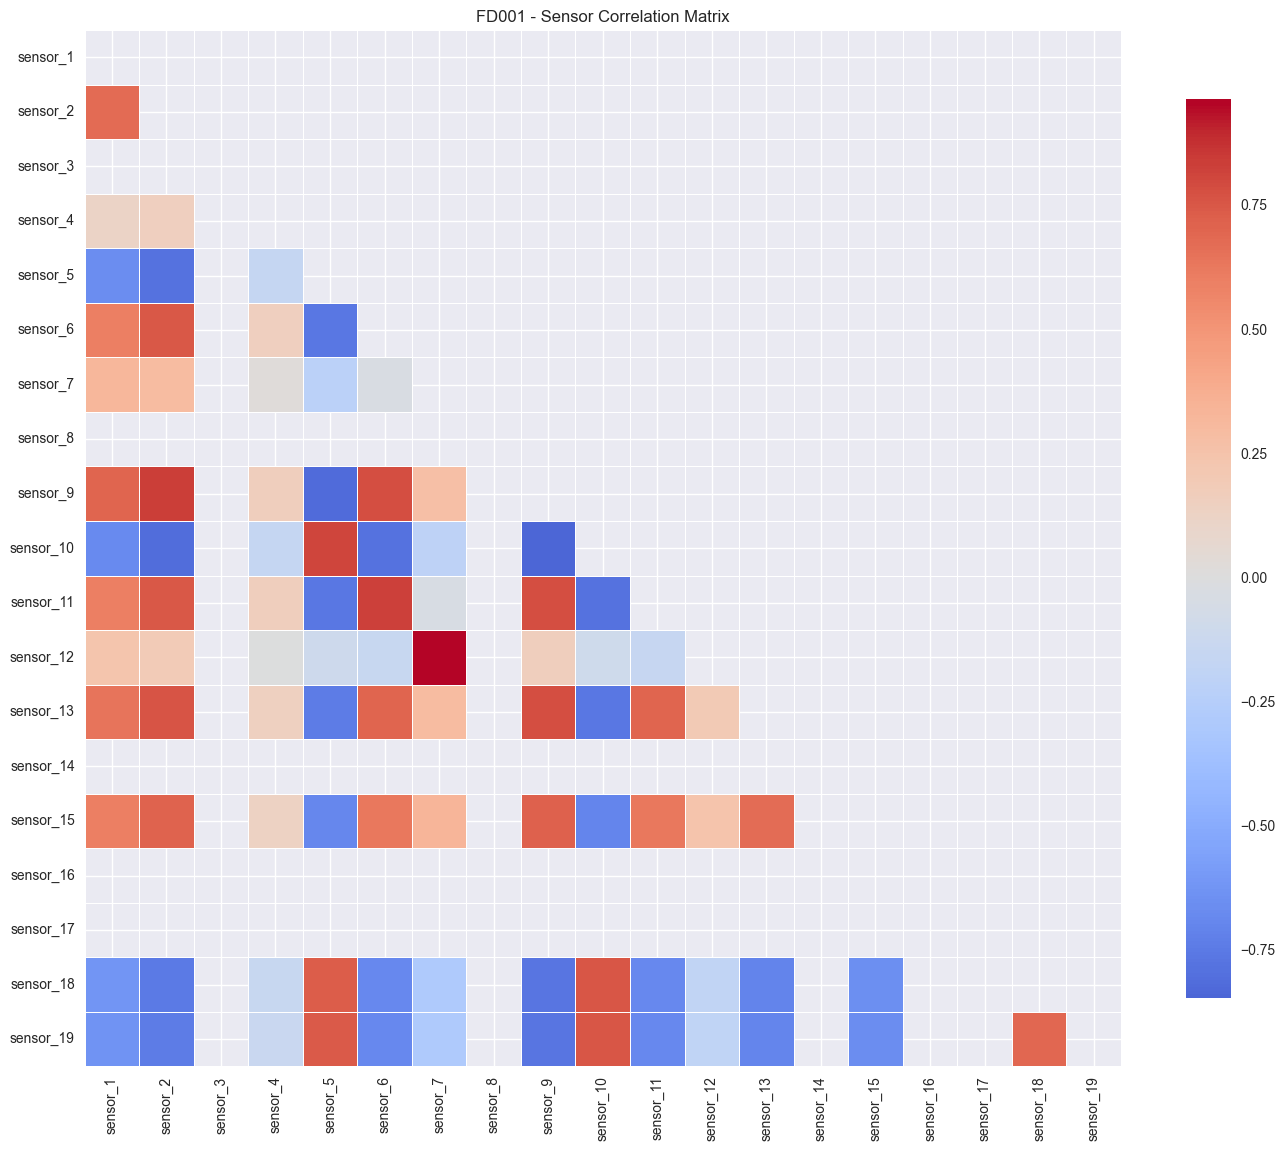


FD001 - Highly correlated sensor pairs (|r| > 0.8):
sensor_2 - sensor_9: 0.830
sensor_2 - sensor_10: -0.816
sensor_5 - sensor_9: -0.823
sensor_5 - sensor_10: 0.813
sensor_6 - sensor_11: 0.826
sensor_7 - sensor_12: 0.963
sensor_9 - sensor_10: -0.847


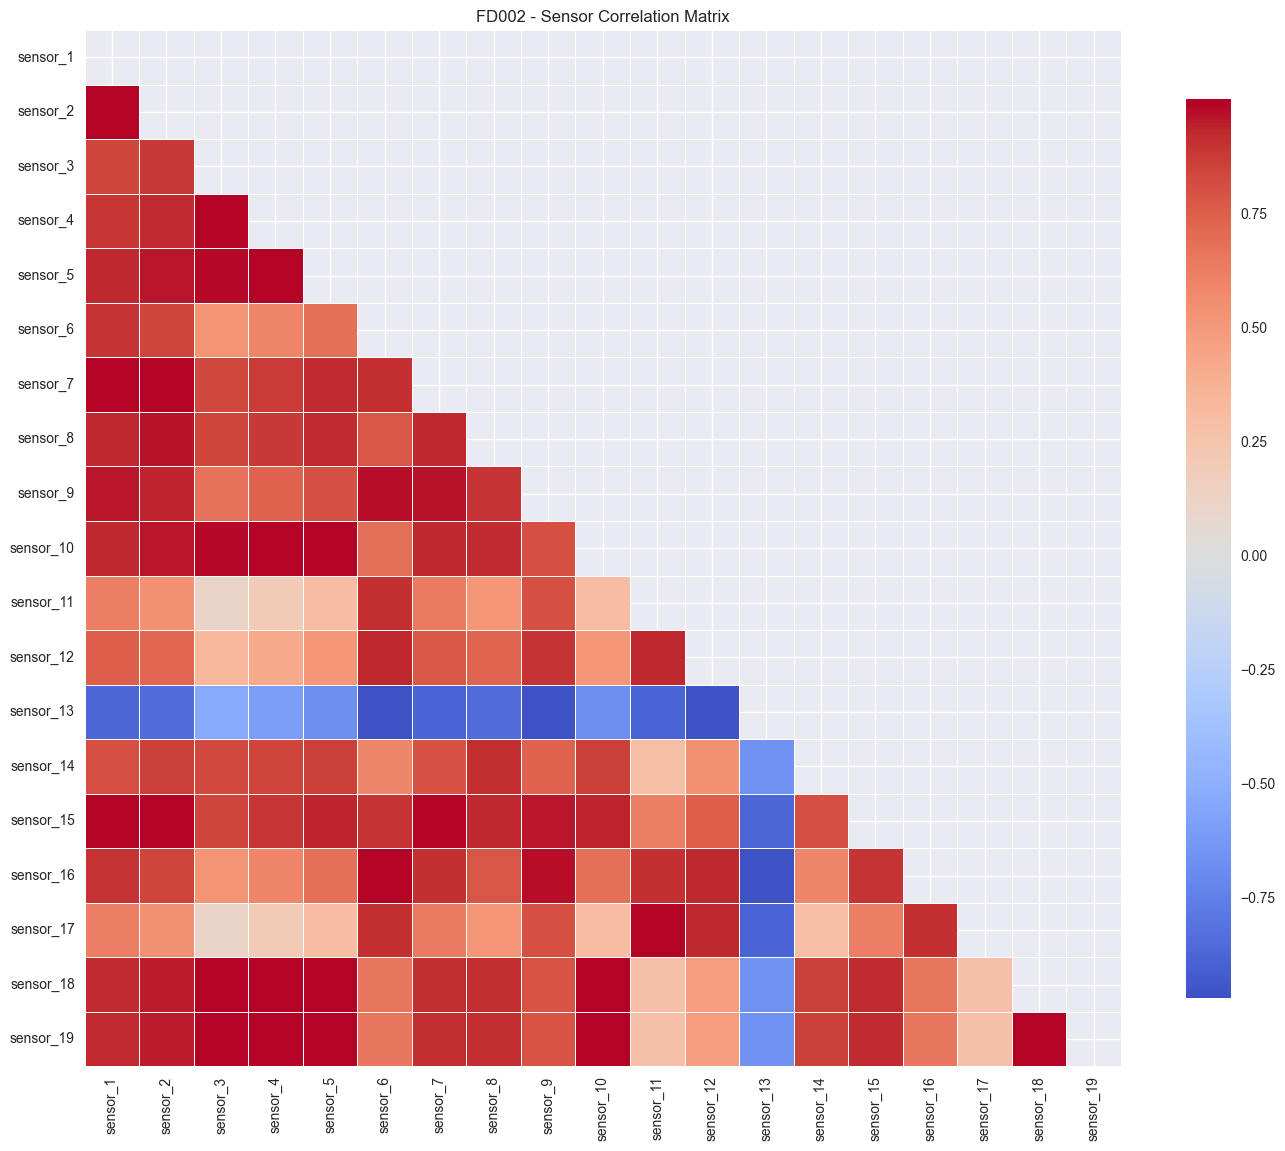


FD002 - Highly correlated sensor pairs (|r| > 0.8):
sensor_1 - sensor_2: 0.990
sensor_1 - sensor_3: 0.843
sensor_1 - sensor_4: 0.885
sensor_1 - sensor_5: 0.929
sensor_1 - sensor_6: 0.896
sensor_1 - sensor_7: 0.998
sensor_1 - sensor_8: 0.929
sensor_1 - sensor_9: 0.961
sensor_1 - sensor_10: 0.930
sensor_1 - sensor_13: -0.876
sensor_1 - sensor_14: 0.805
sensor_1 - sensor_15: 0.999
sensor_1 - sensor_16: 0.895
sensor_1 - sensor_18: 0.917
sensor_1 - sensor_19: 0.917
sensor_2 - sensor_3: 0.884
sensor_2 - sensor_4: 0.920
sensor_2 - sensor_5: 0.957
sensor_2 - sensor_6: 0.844
sensor_2 - sensor_7: 0.987
sensor_2 - sensor_8: 0.962
sensor_2 - sensor_9: 0.937
sensor_2 - sensor_10: 0.957
sensor_2 - sensor_13: -0.847
sensor_2 - sensor_14: 0.859
sensor_2 - sensor_15: 0.990
sensor_2 - sensor_16: 0.844
sensor_2 - sensor_18: 0.946
sensor_2 - sensor_19: 0.946
sensor_3 - sensor_4: 0.996
sensor_3 - sensor_5: 0.980
sensor_3 - sensor_7: 0.833
sensor_3 - sensor_8: 0.844
sensor_3 - sensor_10: 0.979
sensor_3 - s

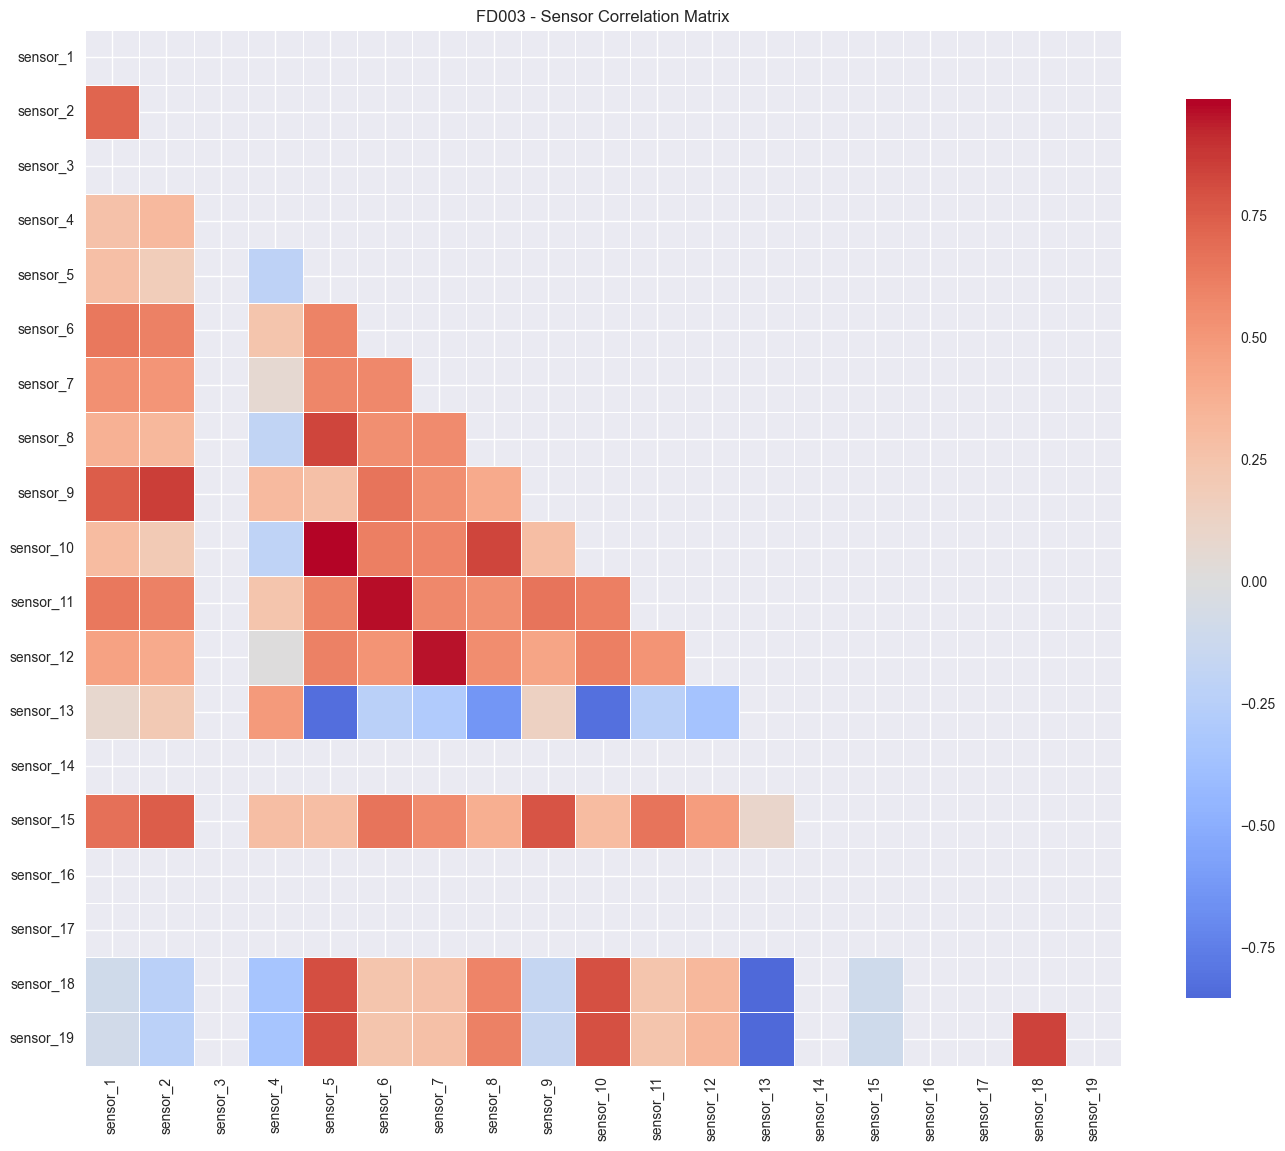


FD003 - Highly correlated sensor pairs (|r| > 0.8):
sensor_2 - sensor_9: 0.854
sensor_5 - sensor_8: 0.831
sensor_5 - sensor_10: 0.989
sensor_5 - sensor_13: -0.827
sensor_5 - sensor_18: 0.803
sensor_5 - sensor_19: 0.807
sensor_6 - sensor_11: 0.964
sensor_7 - sensor_12: 0.954
sensor_8 - sensor_10: 0.836
sensor_10 - sensor_13: -0.820
sensor_10 - sensor_19: 0.800
sensor_13 - sensor_18: -0.850
sensor_13 - sensor_19: -0.852
sensor_18 - sensor_19: 0.839


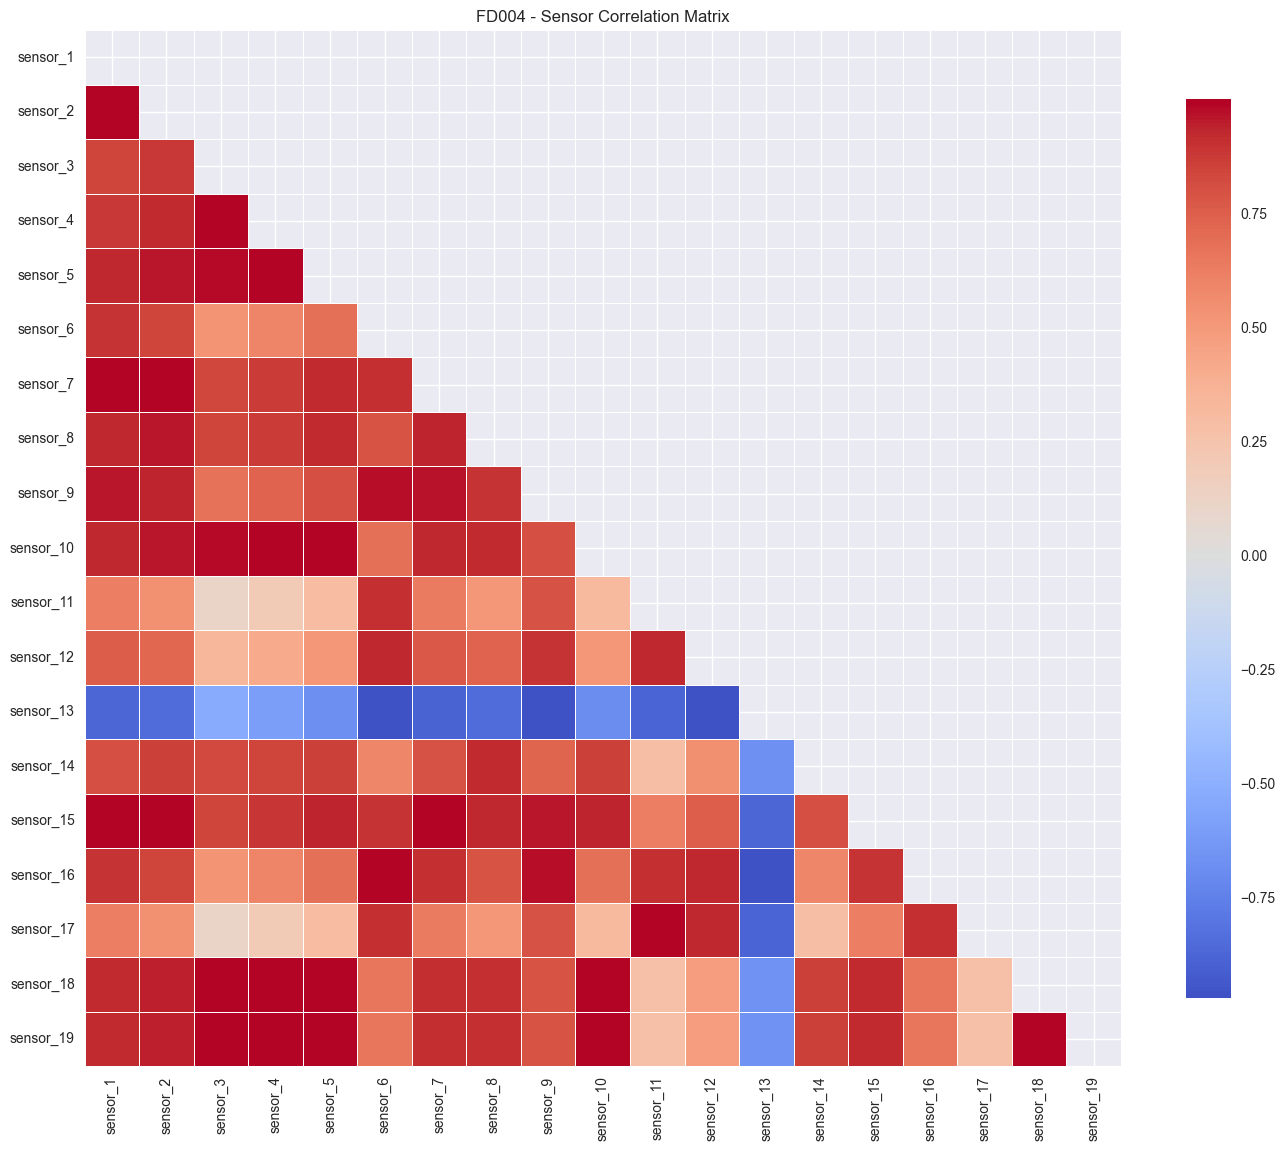


FD004 - Highly correlated sensor pairs (|r| > 0.8):
sensor_1 - sensor_2: 0.990
sensor_1 - sensor_3: 0.843
sensor_1 - sensor_4: 0.885
sensor_1 - sensor_5: 0.929
sensor_1 - sensor_6: 0.895
sensor_1 - sensor_7: 0.998
sensor_1 - sensor_8: 0.930
sensor_1 - sensor_9: 0.961
sensor_1 - sensor_10: 0.929
sensor_1 - sensor_13: -0.875
sensor_1 - sensor_14: 0.802
sensor_1 - sensor_15: 0.999
sensor_1 - sensor_16: 0.895
sensor_1 - sensor_18: 0.917
sensor_1 - sensor_19: 0.917
sensor_2 - sensor_3: 0.884
sensor_2 - sensor_4: 0.919
sensor_2 - sensor_5: 0.956
sensor_2 - sensor_6: 0.844
sensor_2 - sensor_7: 0.988
sensor_2 - sensor_8: 0.961
sensor_2 - sensor_9: 0.937
sensor_2 - sensor_10: 0.957
sensor_2 - sensor_13: -0.846
sensor_2 - sensor_14: 0.859
sensor_2 - sensor_15: 0.990
sensor_2 - sensor_16: 0.844
sensor_2 - sensor_18: 0.946
sensor_2 - sensor_19: 0.946
sensor_3 - sensor_4: 0.996
sensor_3 - sensor_5: 0.980
sensor_3 - sensor_7: 0.833
sensor_3 - sensor_8: 0.841
sensor_3 - sensor_10: 0.979
sensor_3 - s

In [9]:
# Sensor Correlation Analysis
def plot_sensor_correlations(dataset_name):
    """Plot correlation matrix for sensors"""
    train_df = datasets[dataset_name]['train']
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]

    # Calculate correlation matrix
    corr_matrix = train_df[sensor_cols].corr()

    # Create heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title(f'{dataset_name} - Sensor Correlation Matrix')
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_sensor_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find highly correlated sensor pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.8:  # High correlation threshold
                high_corr_pairs.append({
                    'sensor1': corr_matrix.columns[i],
                    'sensor2': corr_matrix.columns[j],
                    'correlation': corr_val
                })

    if high_corr_pairs:
        print(f"\n{dataset_name} - Highly correlated sensor pairs (|r| > 0.8):")
        for pair in high_corr_pairs:
            print(f"{pair['sensor1']} - {pair['sensor2']}: {pair['correlation']:.3f}")

    return corr_matrix

# Plot correlations for all datasets
correlations = {}
for name in dataset_names:
    correlations[name] = plot_sensor_correlations(name)


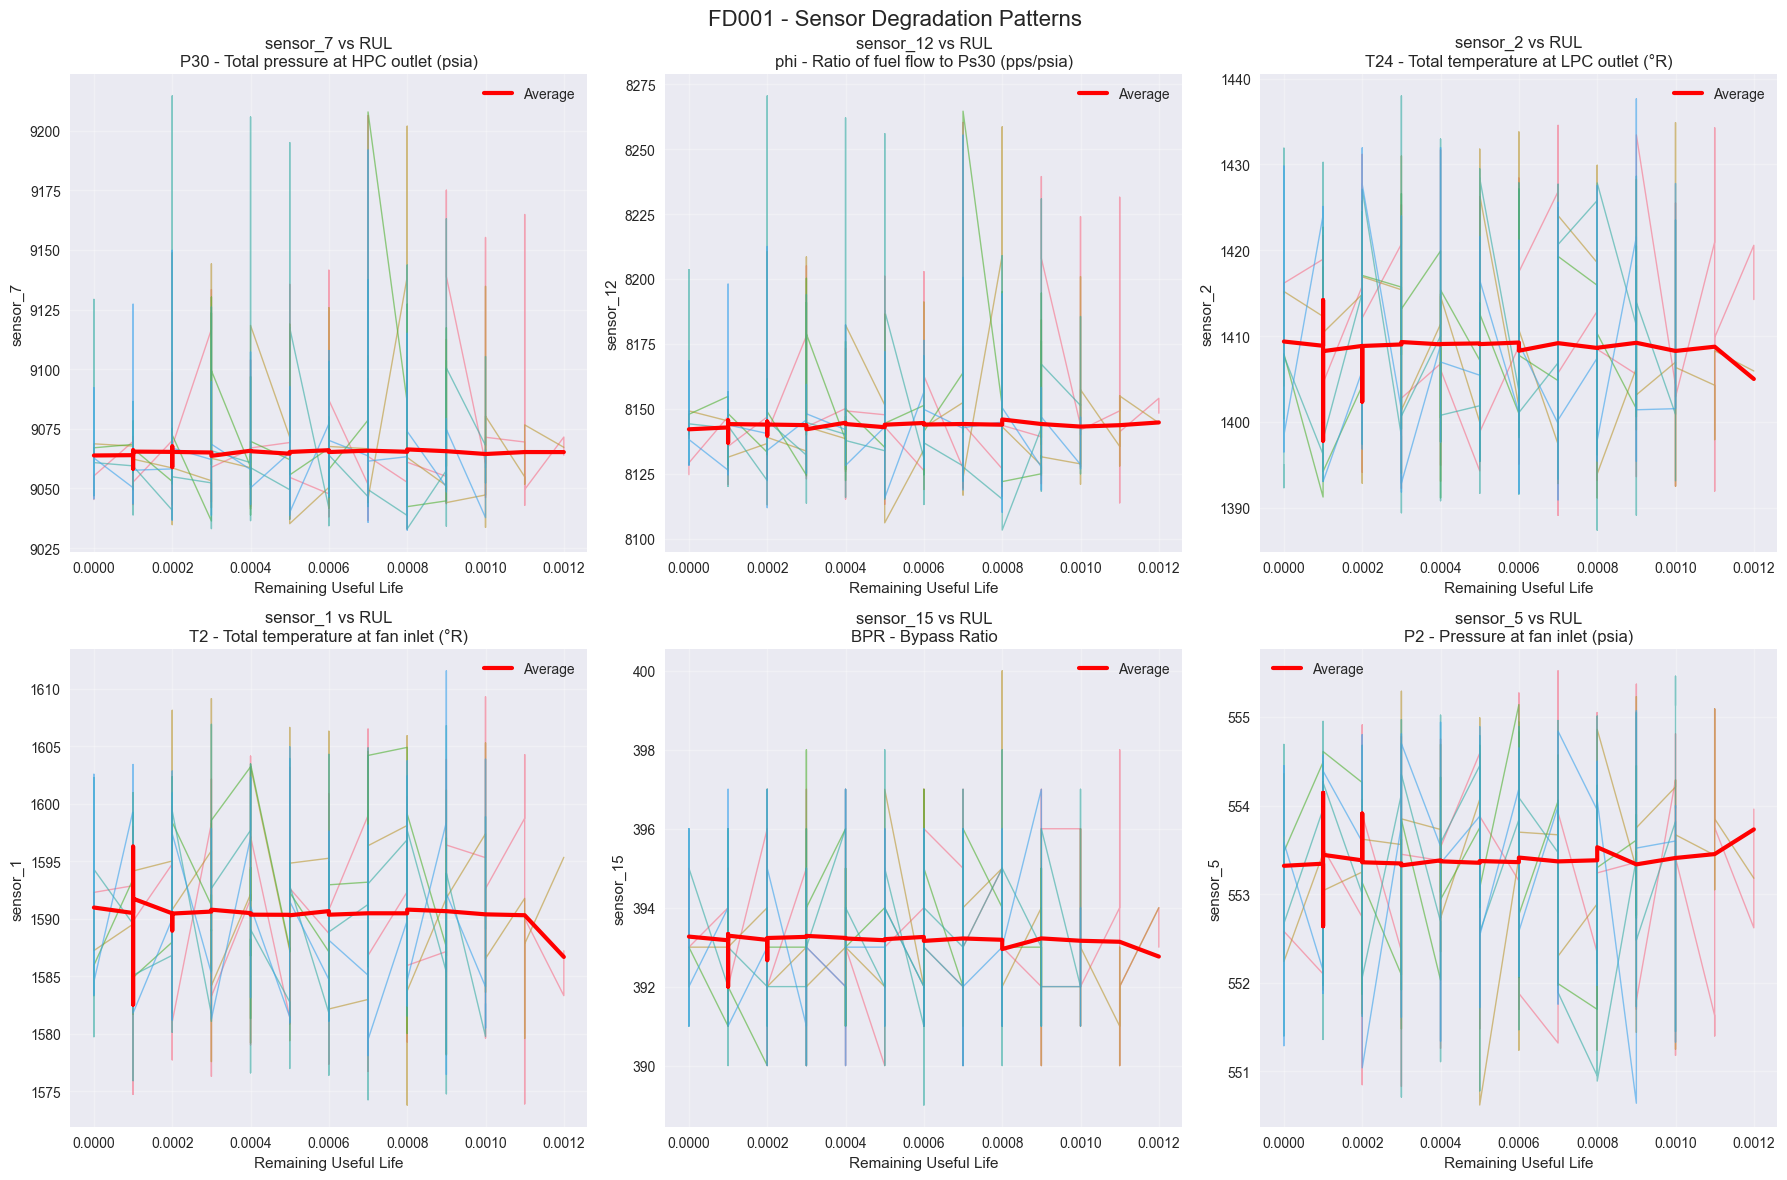

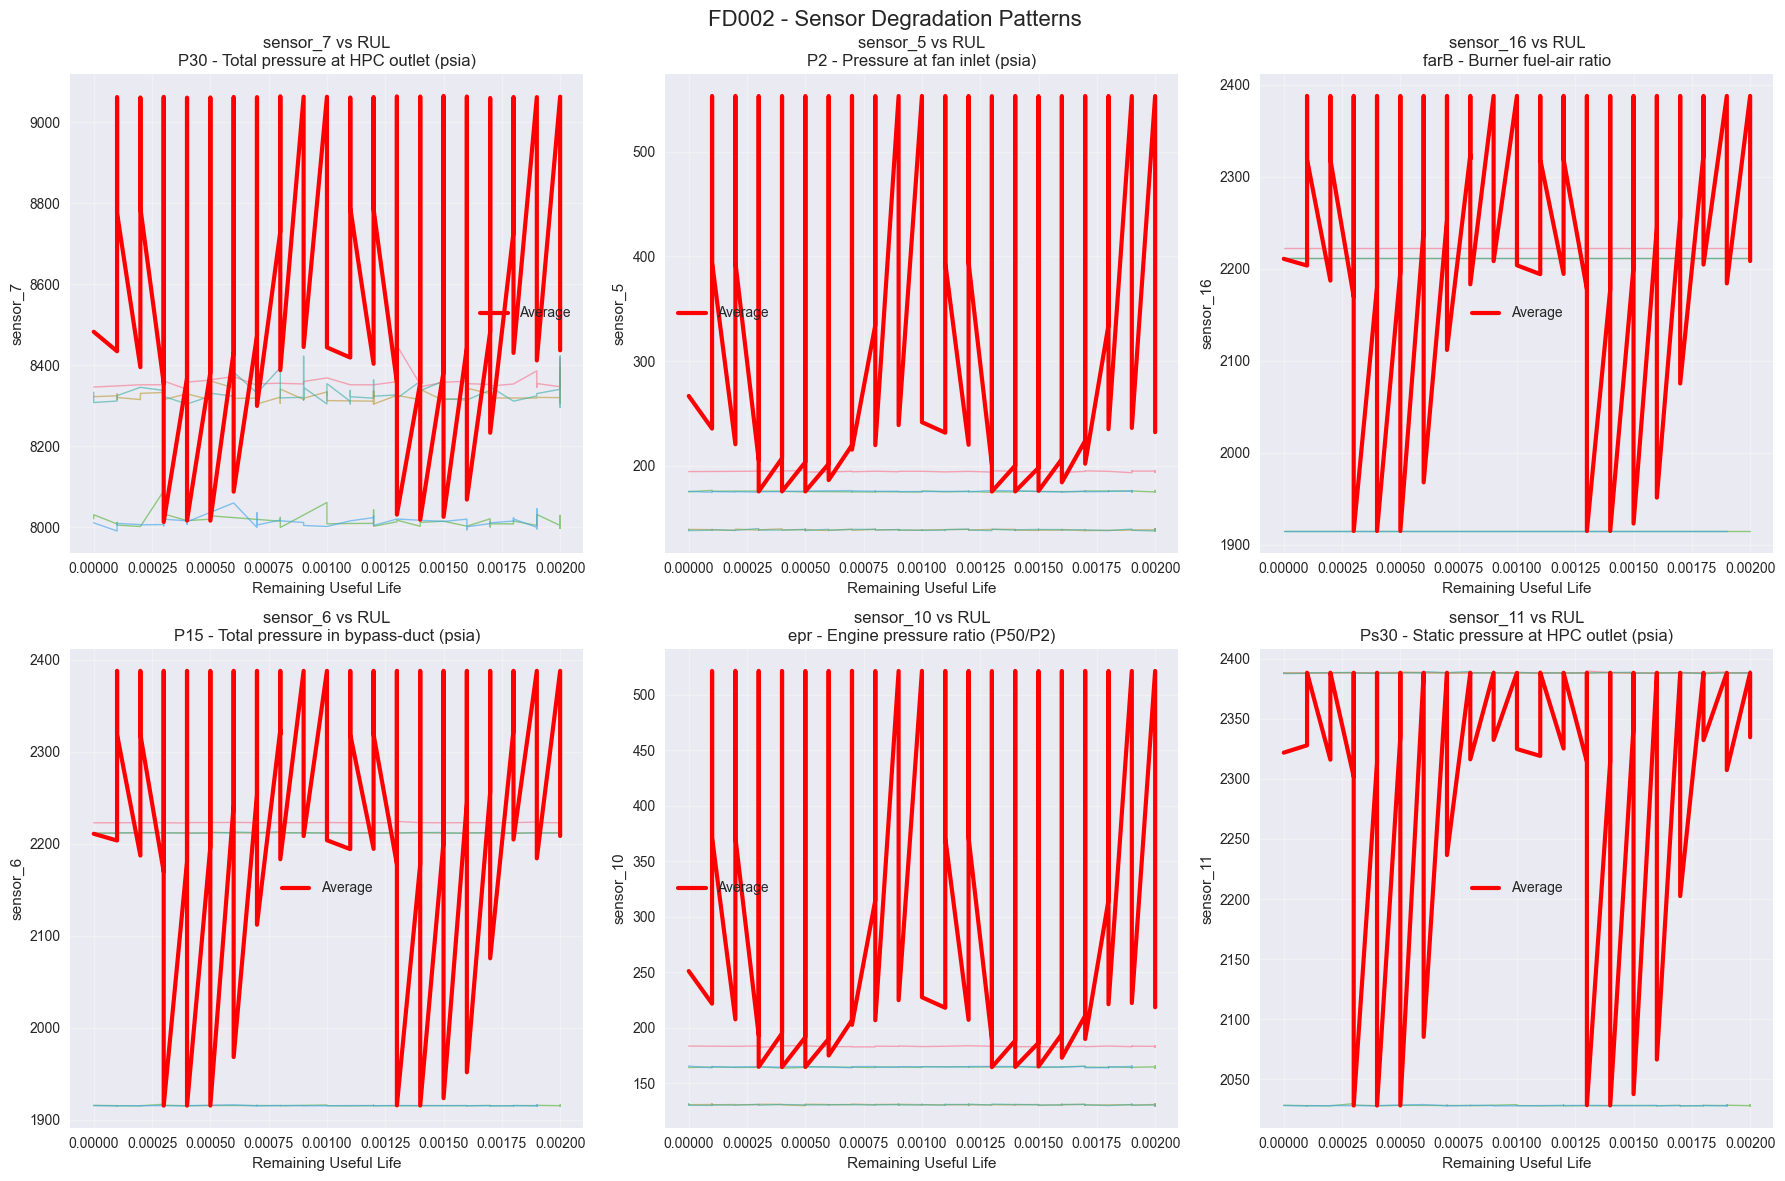

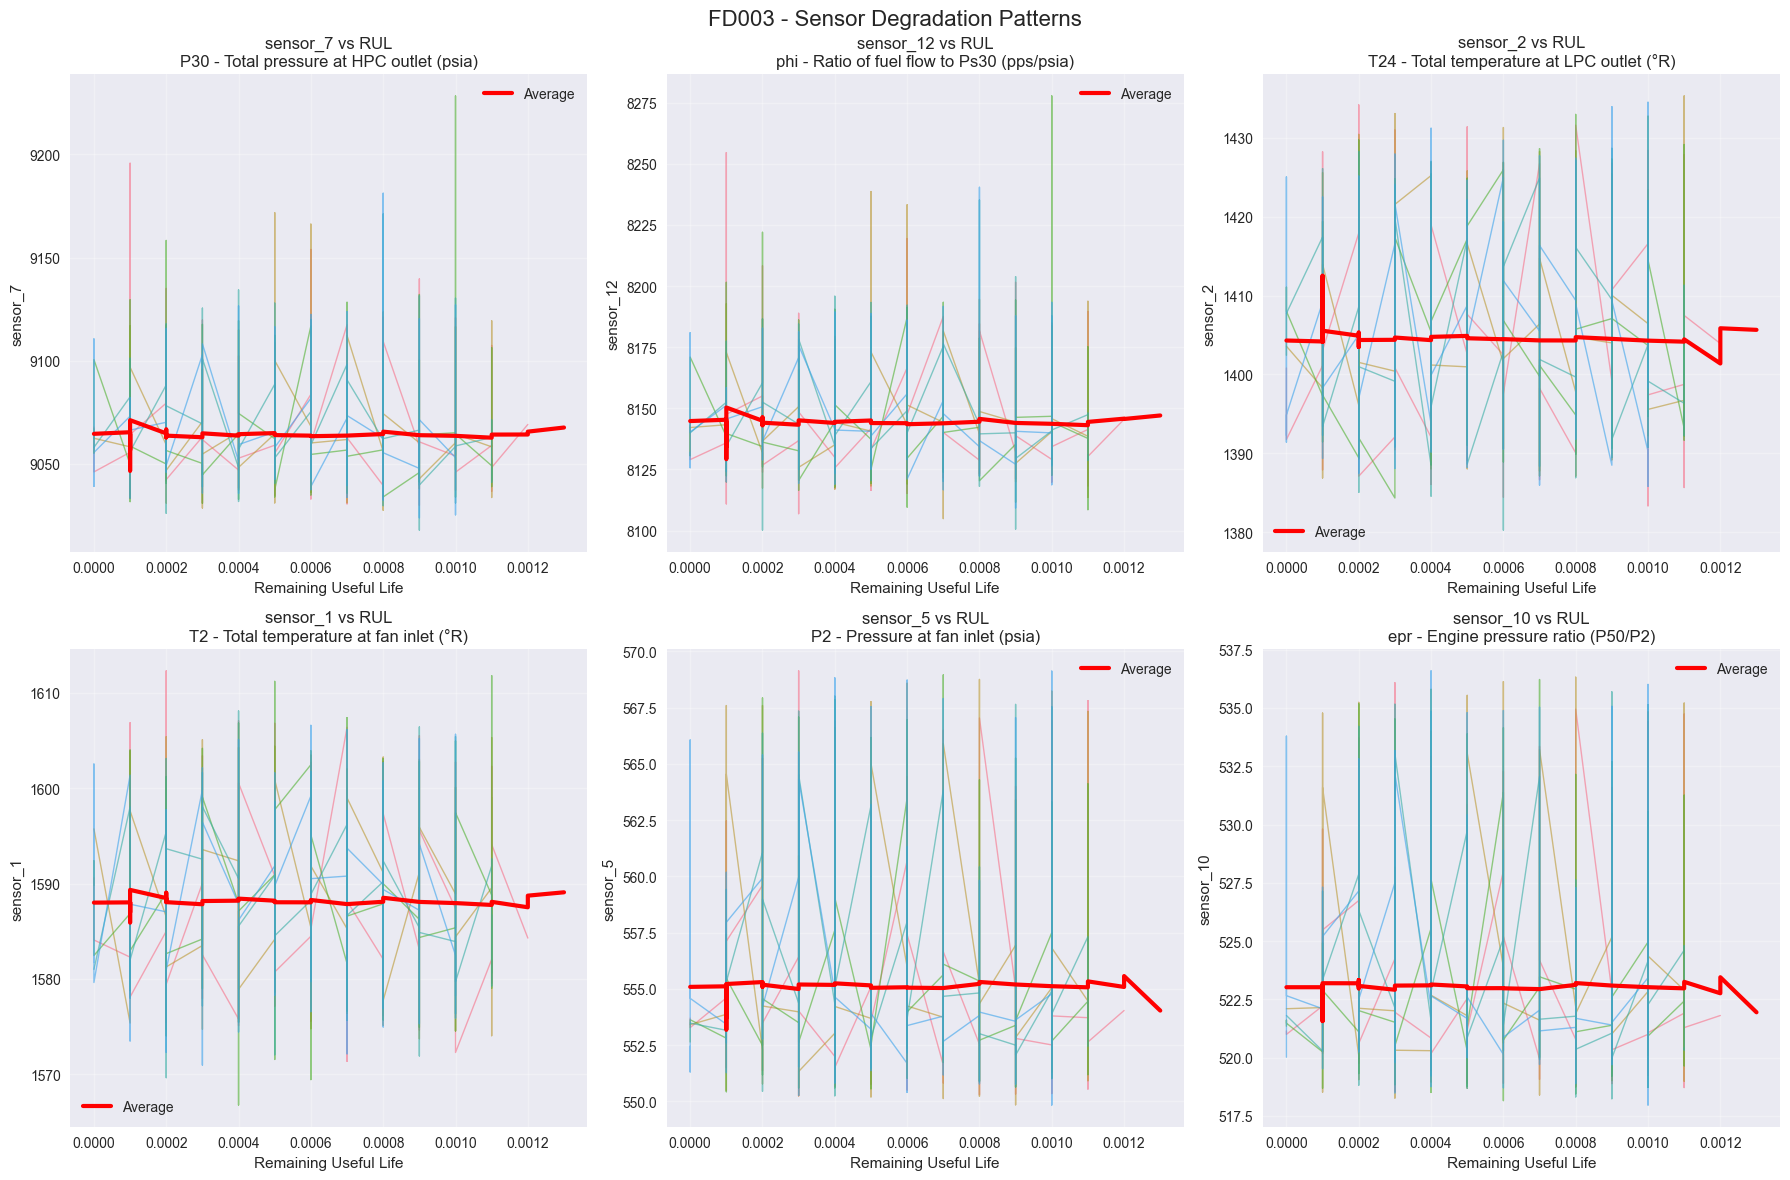

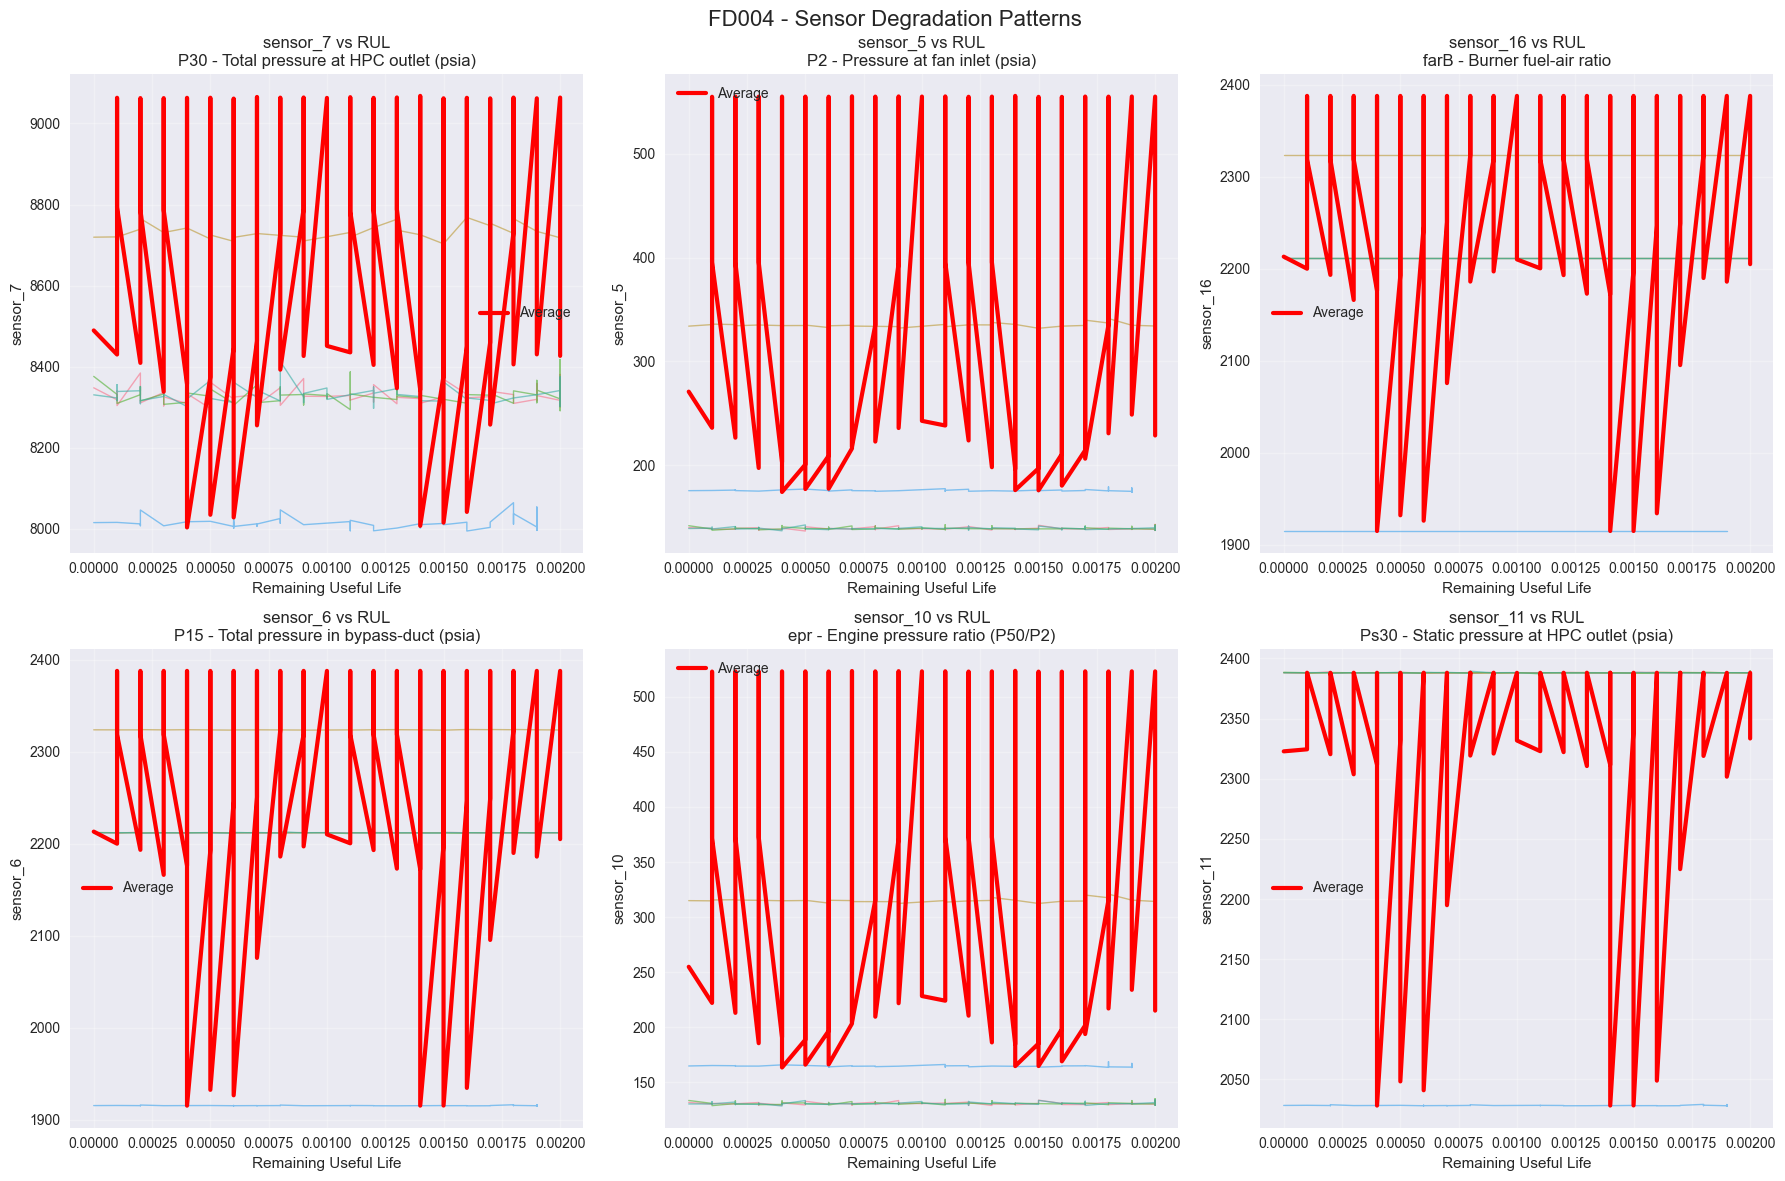

In [10]:
# Sensor Degradation Patterns
def analyze_degradation_patterns(dataset_name, sensors_to_analyze=None):
    """Analyze how sensors change over engine lifecycle"""
    train_df = datasets[dataset_name]['train']

    if sensors_to_analyze is None:
        # Select sensors with highest variance for analysis
        sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
        sensor_vars = train_df[sensor_cols].var().sort_values(ascending=False)
        sensors_to_analyze = sensor_vars.head(6).index.tolist()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, sensor in enumerate(sensors_to_analyze):
        ax = axes[i]

        # Sample a few engines for visualization
        sample_engines = train_df['unit_id'].unique()[:5]

        for engine_id in sample_engines:
            engine_data = train_df[train_df['unit_id'] == engine_id].sort_values('time_cycles')
            ax.plot(engine_data['RUL'], engine_data[sensor], alpha=0.6, linewidth=1)

        # Plot average trend
        avg_trend = train_df.groupby('RUL')[sensor].mean().reset_index()
        ax.plot(avg_trend['RUL'], avg_trend[sensor], 'red', linewidth=3, label='Average')

        ax.set_xlabel('Remaining Useful Life')
        ax.set_ylabel(f'{sensor}')
        ax.set_title(f'{sensor} vs RUL\n{SENSOR_DESCRIPTIONS.get(sensor, "Unknown sensor")}')
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.suptitle(f'{dataset_name} - Sensor Degradation Patterns', fontsize=16)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_degradation_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze degradation patterns for all datasets
for name in dataset_names:
    analyze_degradation_patterns(name)


In [11]:
# Statistical Analysis of Sensor Trends
def calculate_sensor_trends(dataset_name):
    """Calculate correlation between sensors and RUL to identify degradation indicators"""
    train_df = datasets[dataset_name]['train']
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]

    trend_analysis = {}
    for sensor in sensor_cols:
        # Calculate correlation with RUL
        correlation = train_df[sensor].corr(train_df['RUL'])

        # Calculate slope of linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['RUL'], train_df[sensor])

        trend_analysis[sensor] = {
            'correlation_with_rul': correlation,
            'slope': slope,
            'r_squared': r_value**2,
            'p_value': p_value,
            'degradation_indicator': abs(correlation) > 0.3 and p_value < 0.05
        }

    return pd.DataFrame(trend_analysis).T

print("=== SENSOR DEGRADATION TREND ANALYSIS ===\n")
trend_results = {}
for name in dataset_names:
    trend_results[name] = calculate_sensor_trends(name)

    print(f"\n{name} - Strong degradation indicators (|correlation| > 0.3, p < 0.05):")
    strong_indicators = trend_results[name][trend_results[name]['degradation_indicator']]
    if len(strong_indicators) > 0:
        print(strong_indicators[['correlation_with_rul', 'r_squared', 'p_value']].round(4))
    else:
        print("No strong degradation indicators found")


=== SENSOR DEGRADATION TREND ANALYSIS ===


FD001 - Strong degradation indicators (|correlation| > 0.3, p < 0.05):
No strong degradation indicators found

FD002 - Strong degradation indicators (|correlation| > 0.3, p < 0.05):
No strong degradation indicators found

FD003 - Strong degradation indicators (|correlation| > 0.3, p < 0.05):
No strong degradation indicators found

FD004 - Strong degradation indicators (|correlation| > 0.3, p < 0.05):
No strong degradation indicators found


In [12]:
# Data Quality Assessment
def assess_data_quality(dataset_name):
    """Assess data quality including missing values, outliers, and anomalies"""
    train_df = datasets[dataset_name]['train']
    test_df = datasets[dataset_name]['test']

    quality_report = {
        'dataset': dataset_name,
        'train_missing_values': train_df.isnull().sum().sum(),
        'test_missing_values': test_df.isnull().sum().sum(),
        'train_duplicates': train_df.duplicated().sum(),
        'test_duplicates': test_df.duplicated().sum(),
        'train_shape': train_df.shape,
        'test_shape': test_df.shape
    }

    # Check for outliers using IQR method
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
    outlier_counts = {}

    for sensor in sensor_cols:
        Q1 = train_df[sensor].quantile(0.25)
        Q3 = train_df[sensor].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((train_df[sensor] < lower_bound) | (train_df[sensor] > upper_bound)).sum()
        outlier_counts[sensor] = outliers

    quality_report['outlier_counts'] = outlier_counts
    quality_report['total_outliers'] = sum(outlier_counts.values())

    return quality_report

print("\n=== DATA QUALITY ASSESSMENT ===\n")
quality_reports = {}
for name in dataset_names:
    quality_reports[name] = assess_data_quality(name)
    report = quality_reports[name]

    print(f"{name}:")
    print(f"  Train shape: {report['train_shape']}")
    print(f"  Test shape: {report['test_shape']}")
    print(f"  Missing values (train/test): {report['train_missing_values']}/{report['test_missing_values']}")
    print(f"  Duplicates (train/test): {report['train_duplicates']}/{report['test_duplicates']}")
    print(f"  Total outliers: {report['total_outliers']}")
    print()



=== DATA QUALITY ASSESSMENT ===

FD001:
  Train shape: (20631, 26)
  Test shape: (13096, 24)
  Missing values (train/test): 0/0
  Duplicates (train/test): 0/0
  Total outliers: 5278

FD002:
  Train shape: (53759, 26)
  Test shape: (33991, 24)
  Missing values (train/test): 0/0
  Duplicates (train/test): 0/0
  Total outliers: 53130

FD003:
  Train shape: (24720, 26)
  Test shape: (16596, 24)
  Missing values (train/test): 0/0
  Duplicates (train/test): 0/0
  Total outliers: 16417

FD004:
  Train shape: (61249, 26)
  Test shape: (41214, 24)
  Missing values (train/test): 0/0
  Duplicates (train/test): 0/0
  Total outliers: 60366



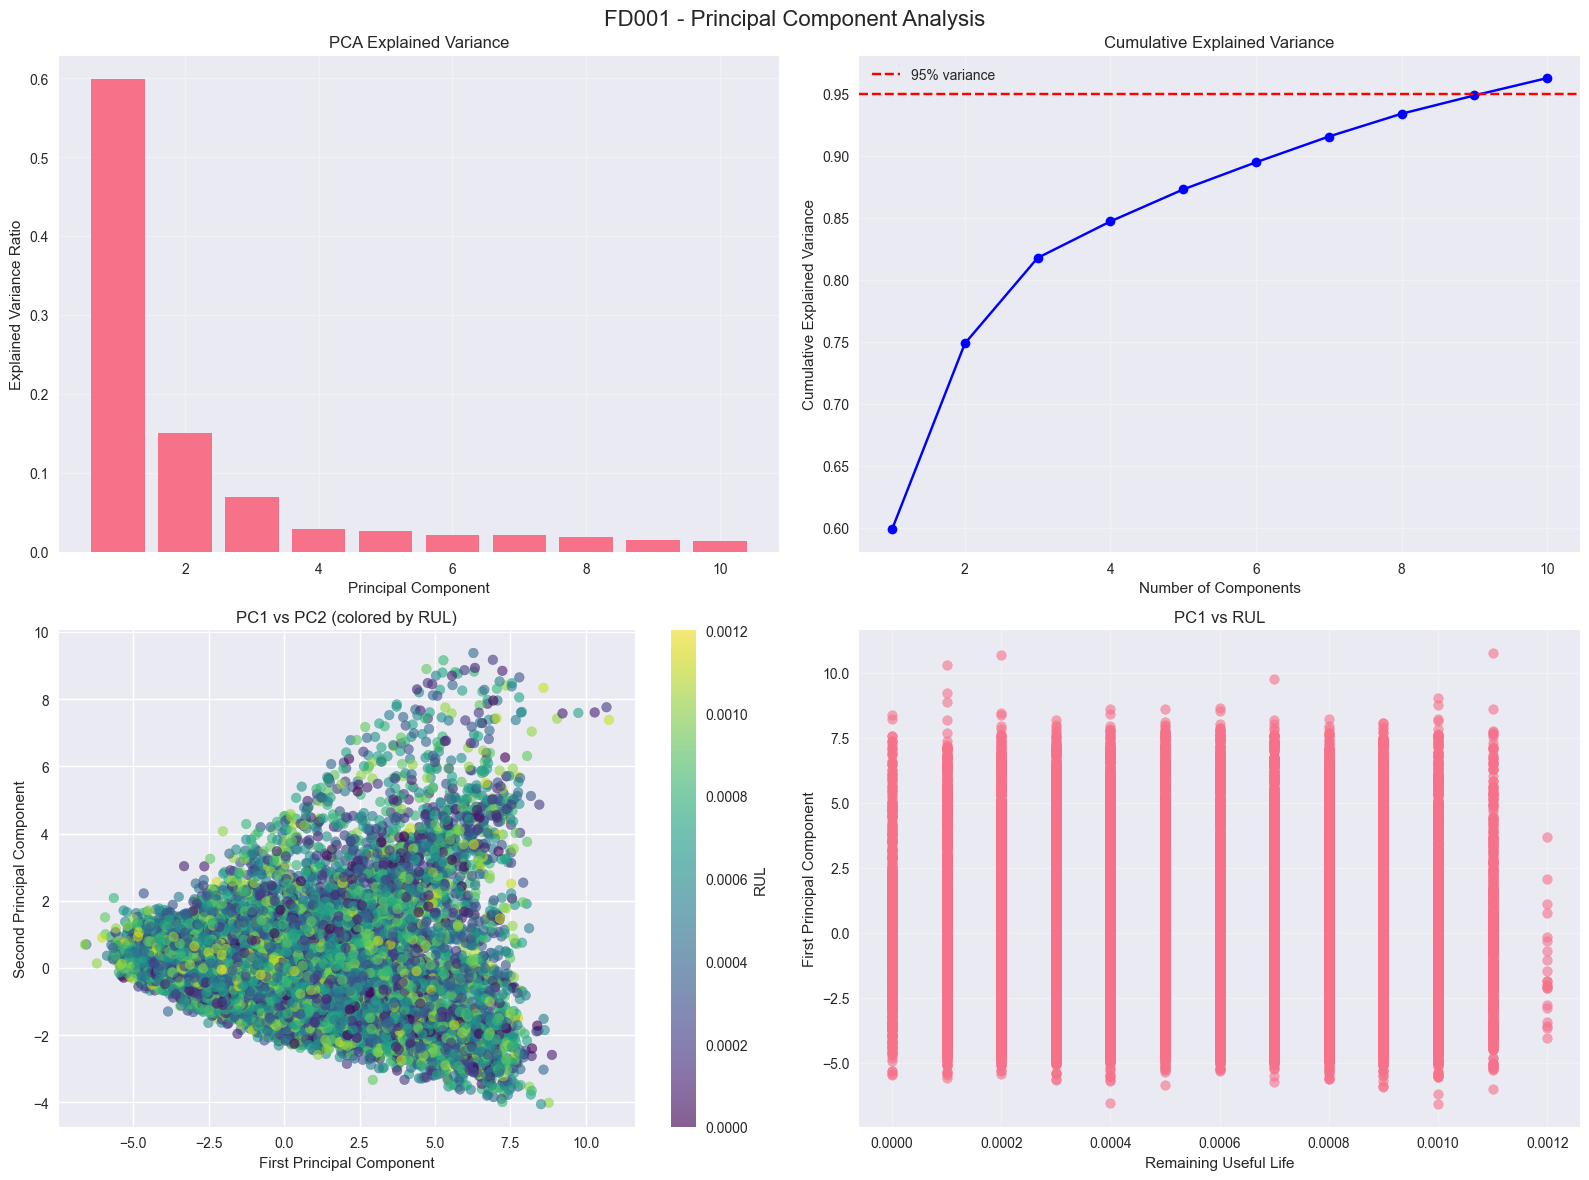


FD001 PCA Results:
Explained variance by first 5 components: [0.599 0.15  0.069 0.029 0.026]
Cumulative variance explained by first 5 components: [0.599 0.749 0.818 0.847 0.873]


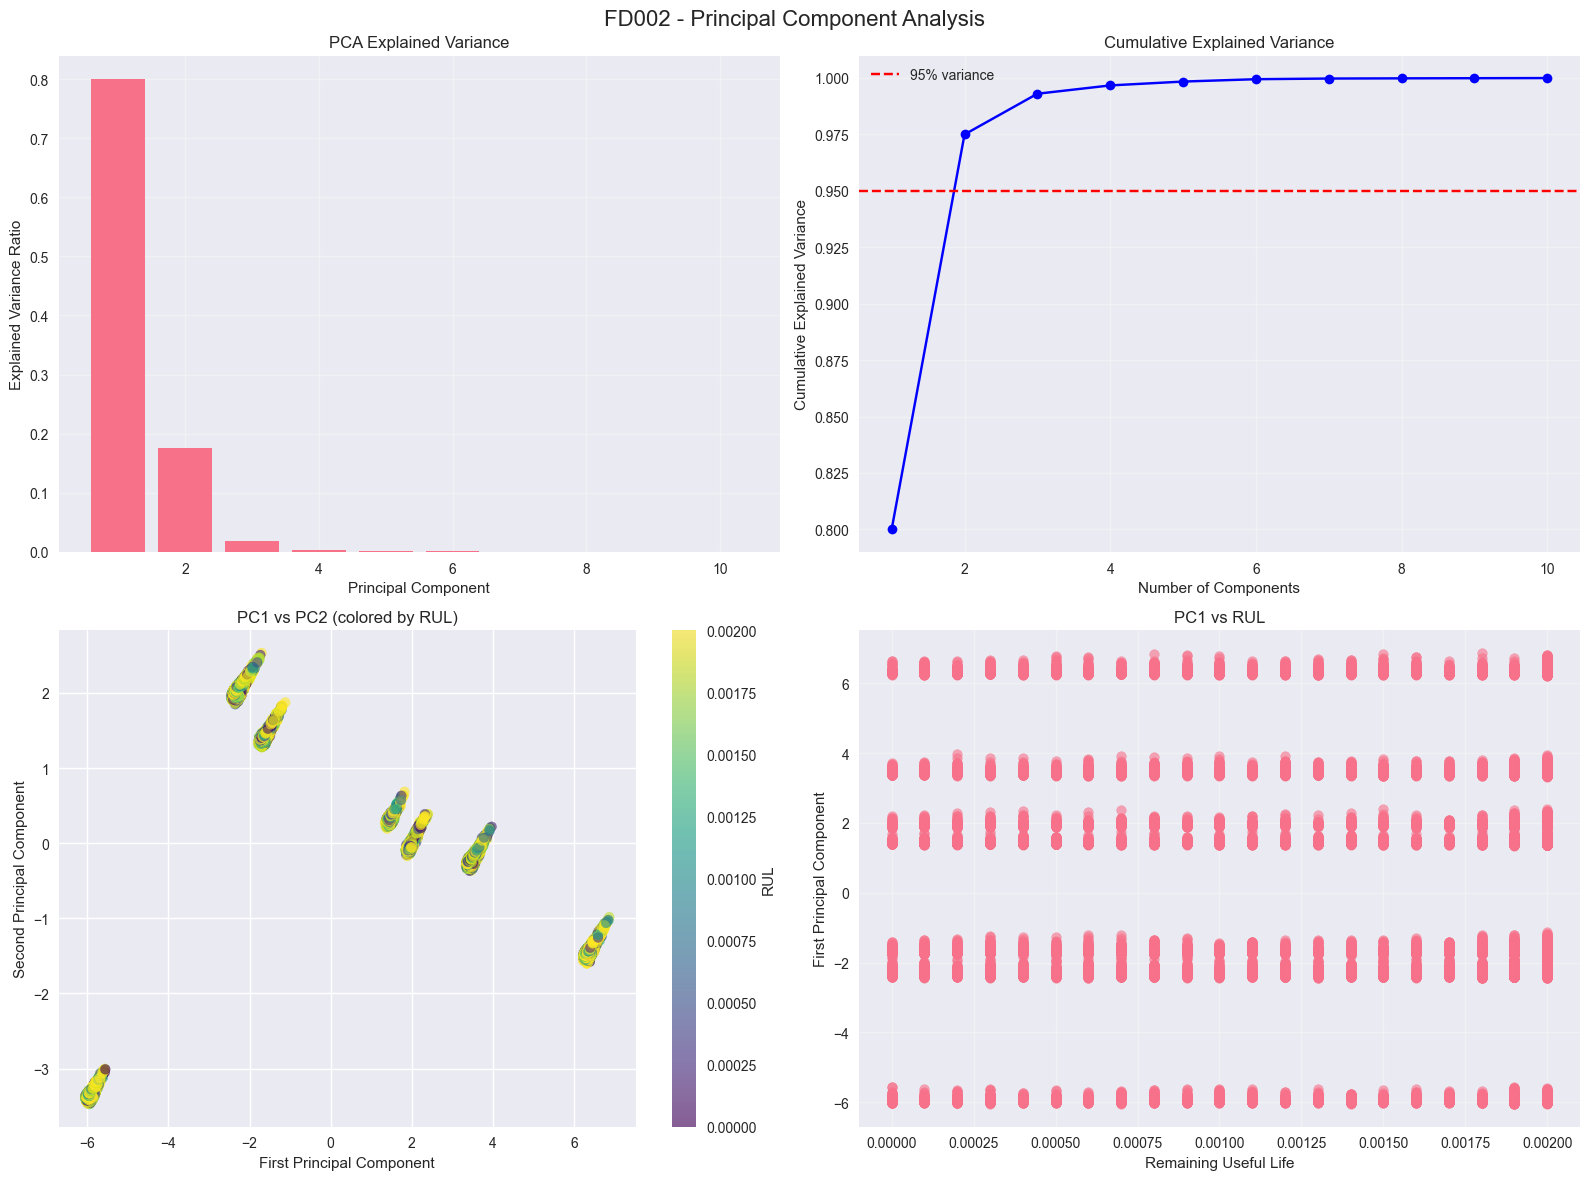


FD002 PCA Results:
Explained variance by first 5 components: [0.8   0.175 0.018 0.004 0.002]
Cumulative variance explained by first 5 components: [0.8   0.975 0.993 0.997 0.998]


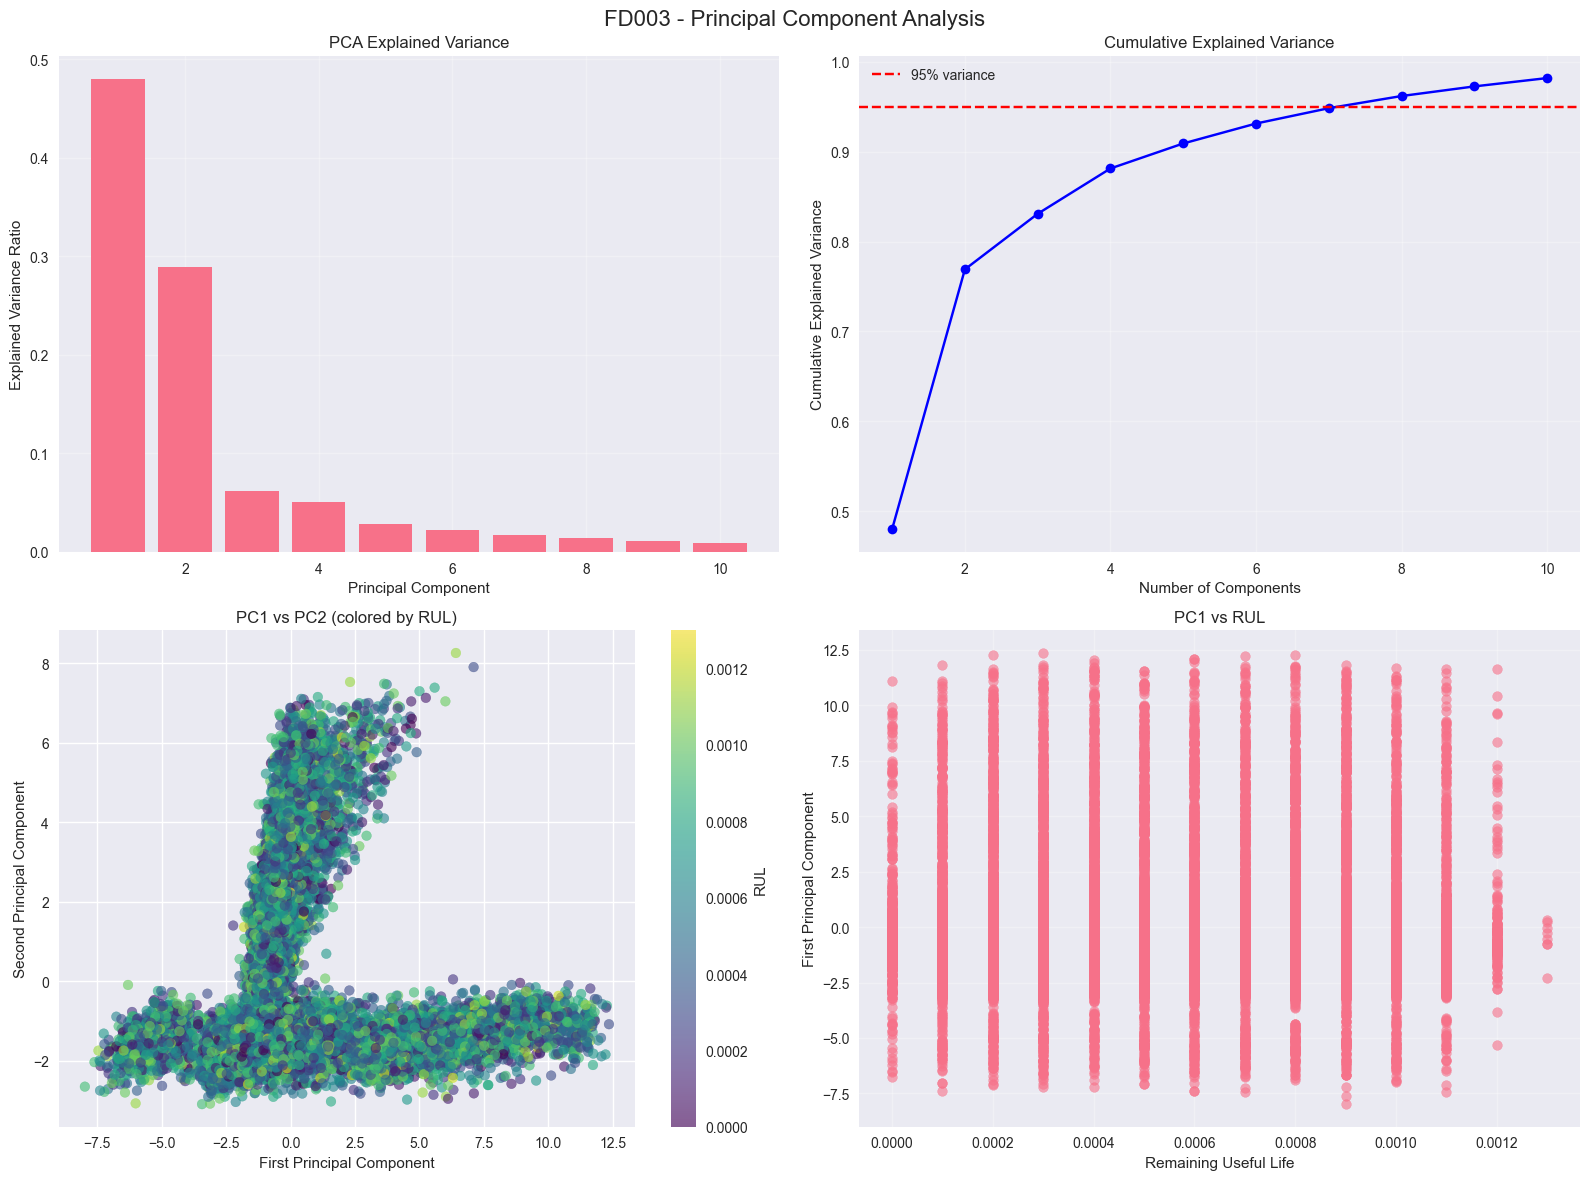


FD003 PCA Results:
Explained variance by first 5 components: [0.48  0.289 0.062 0.05  0.028]
Cumulative variance explained by first 5 components: [0.48  0.769 0.831 0.881 0.909]


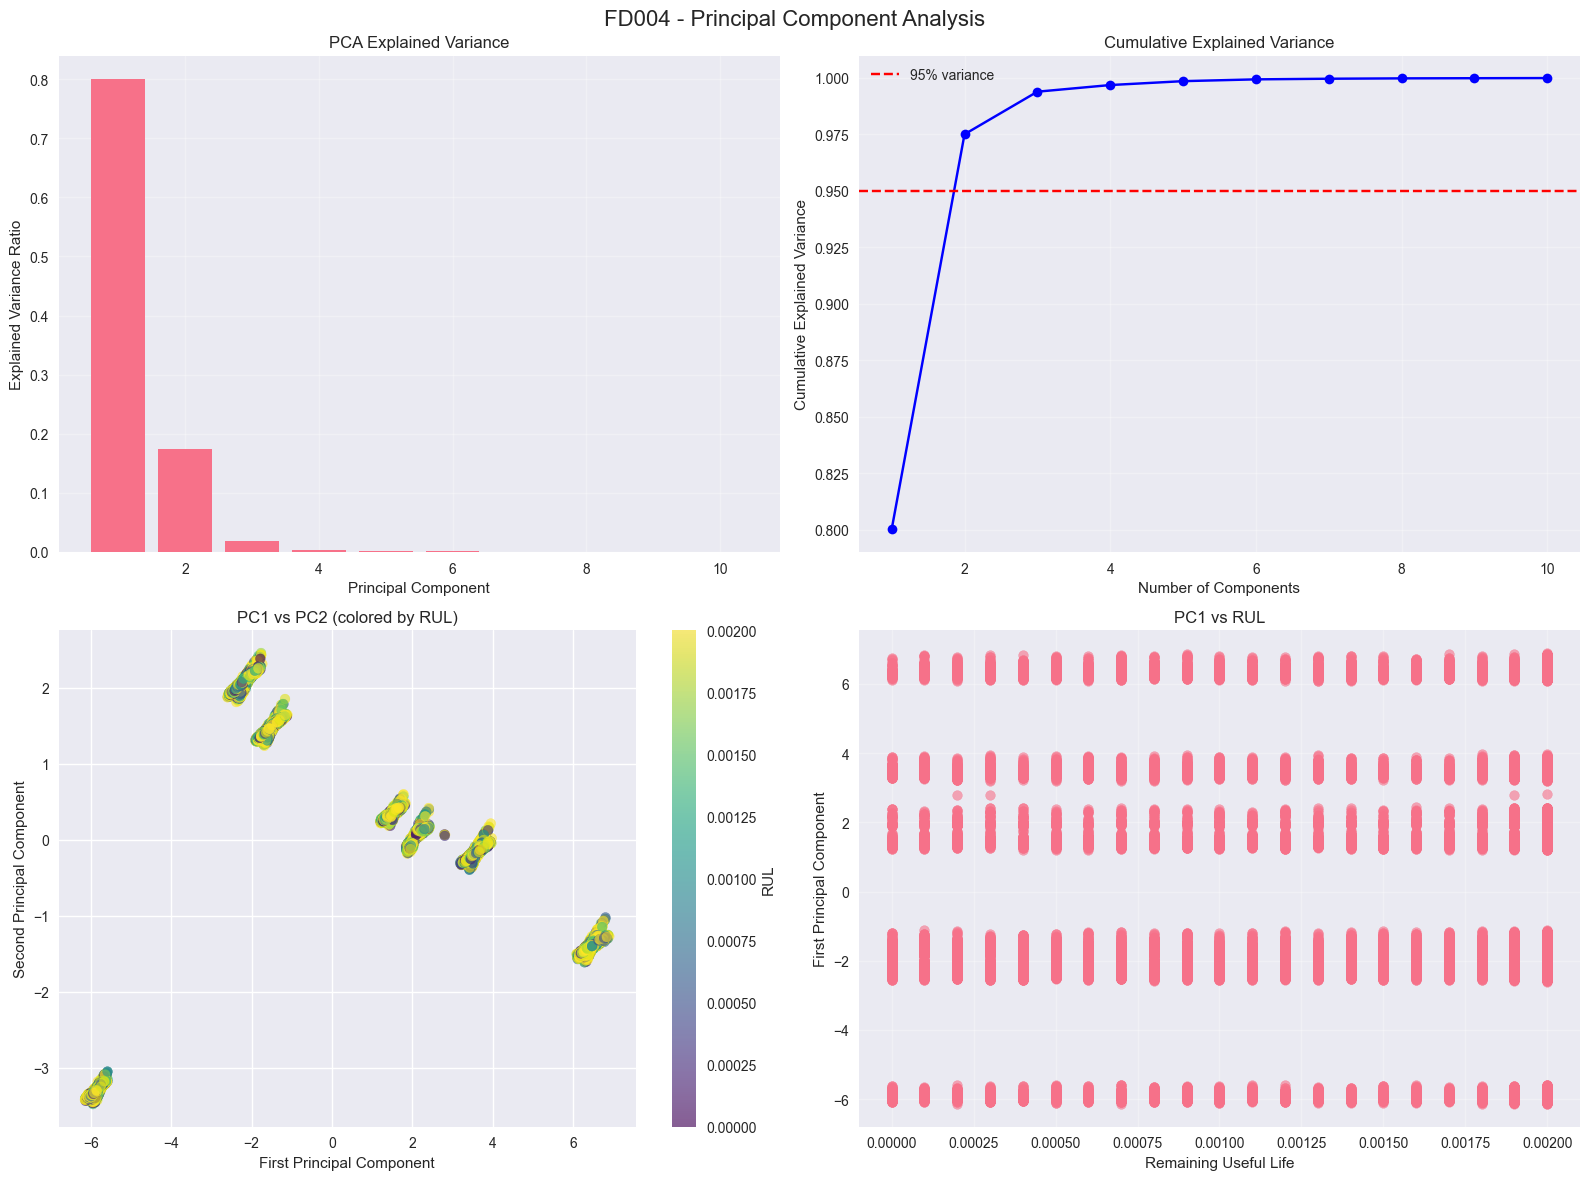


FD004 PCA Results:
Explained variance by first 5 components: [0.8   0.175 0.019 0.003 0.002]
Cumulative variance explained by first 5 components: [0.8   0.975 0.994 0.997 0.999]


In [13]:
# Principal Component Analysis
def perform_pca_analysis(dataset_name, n_components=10):
    """Perform PCA to understand sensor relationships and dimensionality"""
    train_df = datasets[dataset_name]['train']
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]

    # Standardize the data
    scaler = StandardScaler()
    sensor_data_scaled = scaler.fit_transform(train_df[sensor_cols])

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(sensor_data_scaled)

    # Create PCA results dataframe
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['RUL'] = train_df['RUL'].values
    pca_df['unit_id'] = train_df['unit_id'].values

    return pca, pca_df, scaler

def plot_pca_results(dataset_name):
    """Plot PCA results and explained variance"""
    pca, pca_df, scaler = perform_pca_analysis(dataset_name)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Explained variance plot
    axes[0, 0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
                   pca.explained_variance_ratio_)
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].set_title('PCA Explained Variance')
    axes[0, 0].grid(True, alpha=0.3)

    # Cumulative explained variance
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    axes[0, 1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
    axes[0, 1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].set_title('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # PC1 vs PC2 colored by RUL
    scatter = axes[1, 0].scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['RUL'],
                                cmap='viridis', alpha=0.6)
    axes[1, 0].set_xlabel('First Principal Component')
    axes[1, 0].set_ylabel('Second Principal Component')
    axes[1, 0].set_title('PC1 vs PC2 (colored by RUL)')
    plt.colorbar(scatter, ax=axes[1, 0], label='RUL')

    # PC1 vs RUL
    axes[1, 1].scatter(pca_df['RUL'], pca_df['PC1'], alpha=0.6)
    axes[1, 1].set_xlabel('Remaining Useful Life')
    axes[1, 1].set_ylabel('First Principal Component')
    axes[1, 1].set_title('PC1 vs RUL')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f'{dataset_name} - Principal Component Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n{dataset_name} PCA Results:")
    print(f"Explained variance by first 5 components: {pca.explained_variance_ratio_[:5].round(3)}")
    print(f"Cumulative variance explained by first 5 components: {np.cumsum(pca.explained_variance_ratio_[:5]).round(3)}")

# Perform PCA analysis for all datasets
pca_results = {}
for name in dataset_names:
    pca_results[name] = plot_pca_results(name)



=== DATA DRIFT ANALYSIS ===



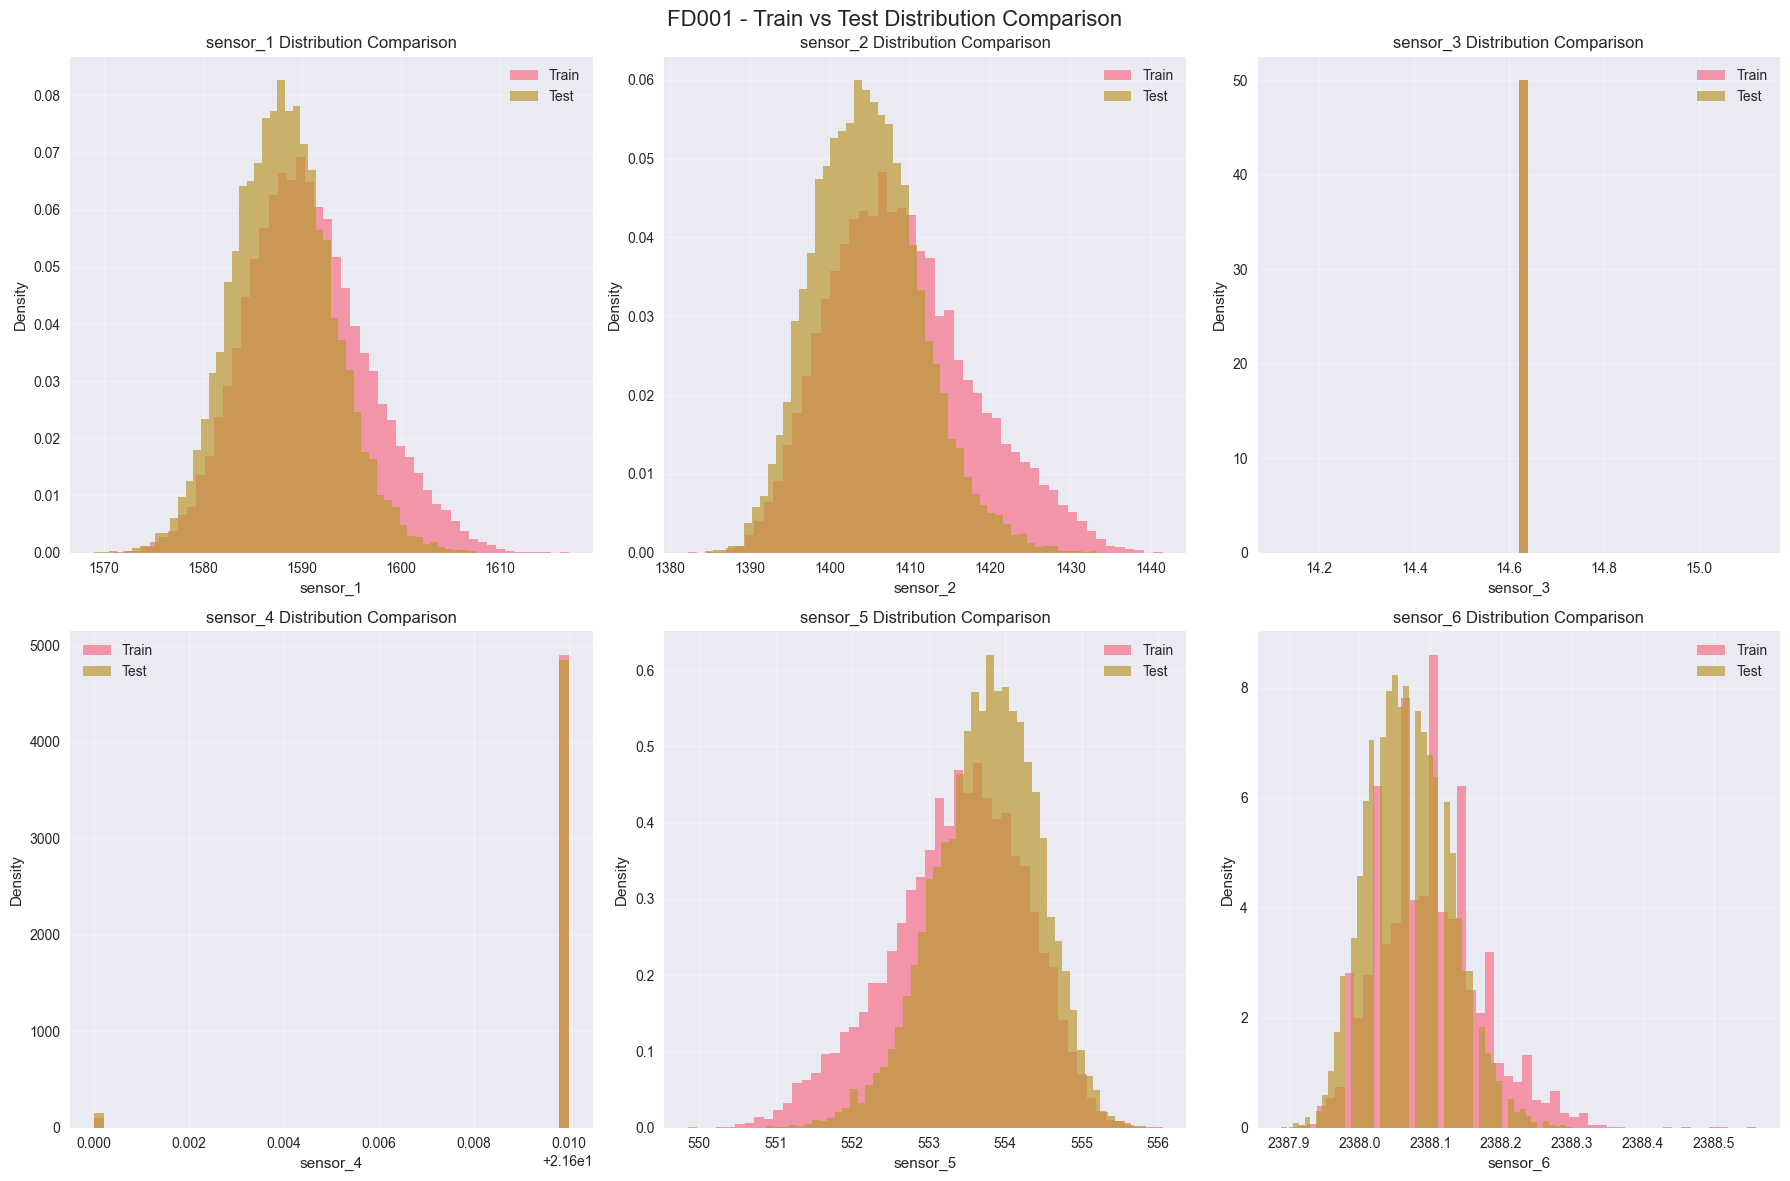

FD001 - Features with potential drift (p < 0.05):
            train_mean    test_mean ks_pvalue mw_pvalue
sensor_1   1590.523119  1588.099204       0.0       0.0
sensor_2   1408.933782  1404.735362       0.0       0.0
sensor_4     21.609803    21.609701  0.366237       0.0
sensor_5    553.367711   553.757523       0.0       0.0
sensor_6   2388.096652  2388.070964       0.0       0.0
sensor_7   9065.242941  9058.407363       0.0       0.0
sensor_9     47.541168    47.416204       0.0       0.0
sensor_10    521.41347   521.747724       0.0       0.0
sensor_11  2388.096152  2388.071025       0.0       0.0
sensor_12  8143.752722  8138.947817       0.0       0.0
sensor_13     8.442146     8.425844       0.0       0.0
sensor_15   393.210654   392.571625       0.0       0.0
sensor_18    38.816271    38.892502       0.0       0.0
sensor_19    23.289705    23.335743       0.0       0.0
setting3    642.680934   642.475088       0.0       0.0



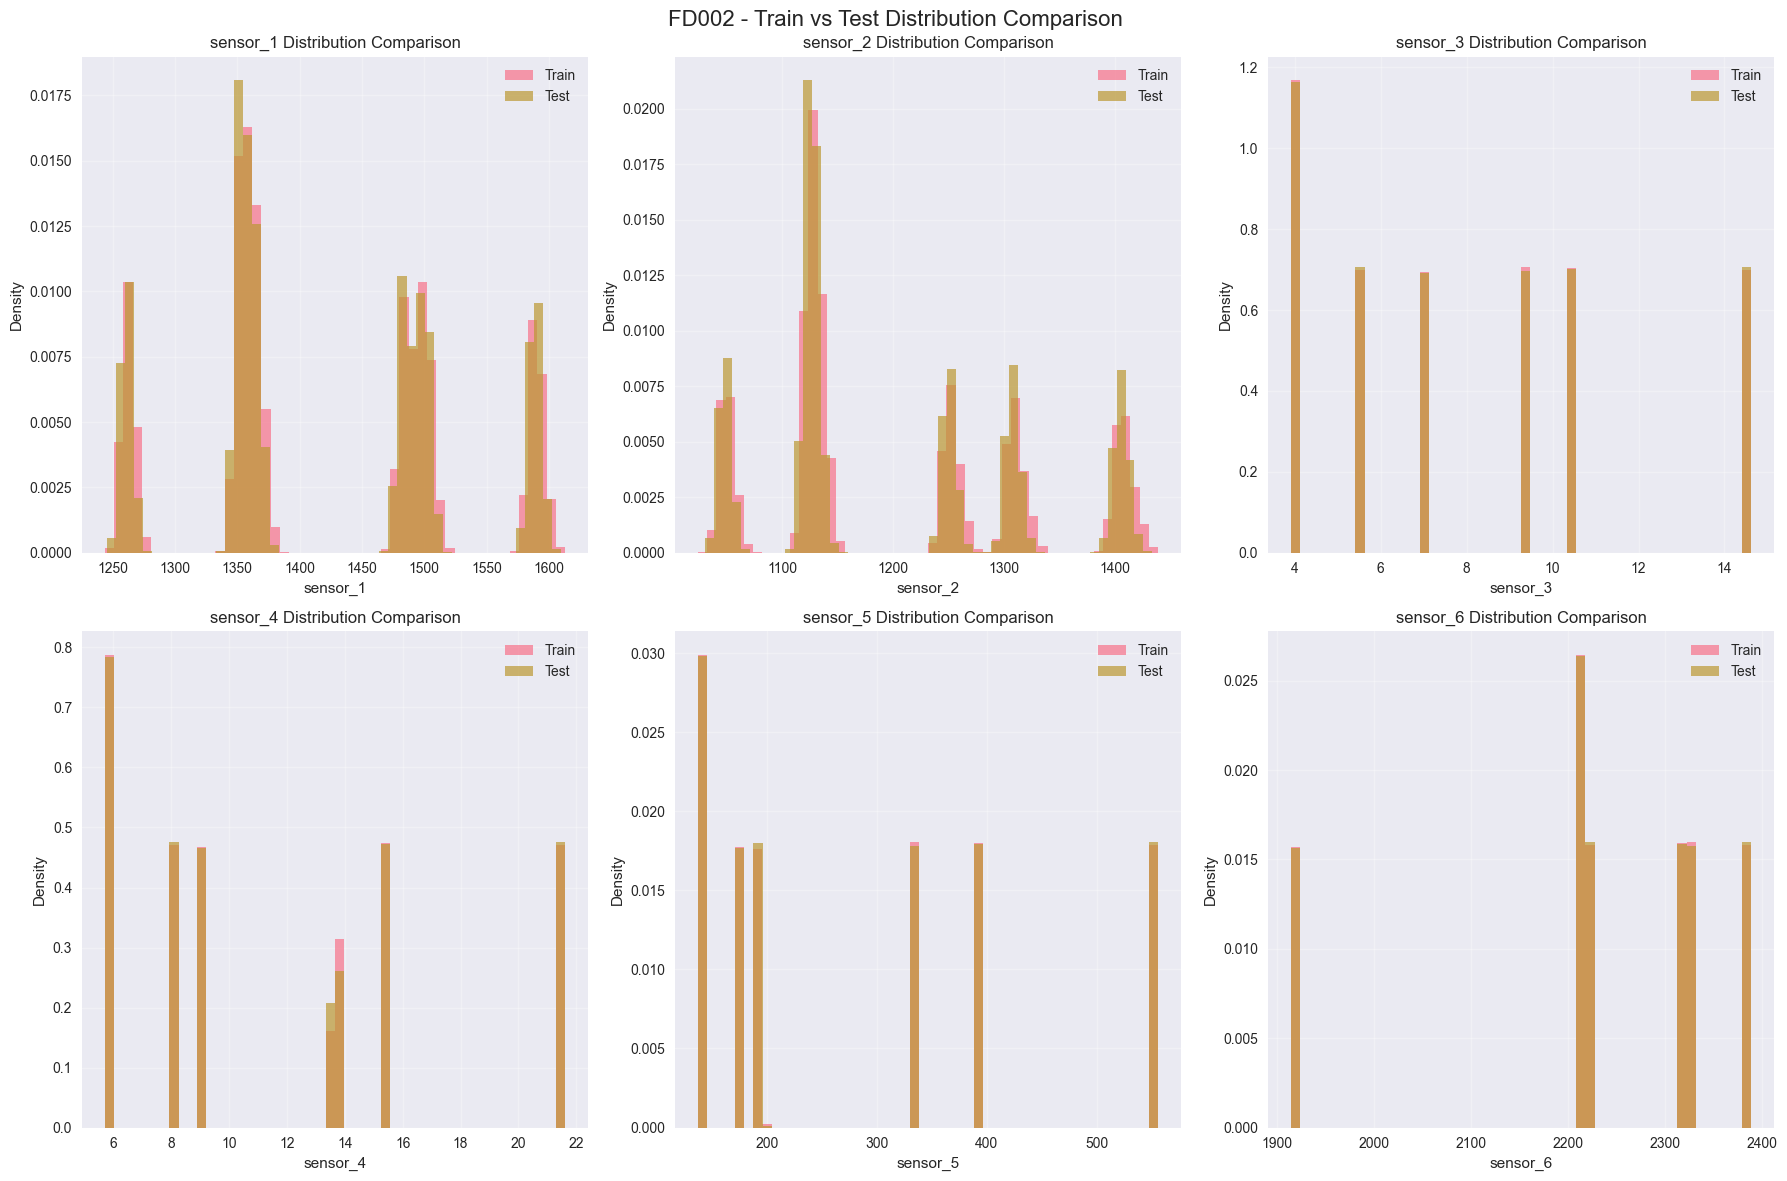

FD002 - Features with potential drift (p < 0.05):
            train_mean    test_mean ks_pvalue mw_pvalue
sensor_1   1419.971013   1418.56209       0.0       0.0
sensor_2   1205.442024  1203.086538       0.0       0.0
sensor_4     11.600746    11.611322       0.0  0.001649
sensor_5    282.606787   283.077917       0.0       0.0
sensor_6   2228.879188  2229.054574       0.0  0.000001
sensor_7   8525.200837  8521.509162       0.0       0.0
sensor_8      1.094962     1.095394  0.002877  0.758668
sensor_9     42.985172    42.910071       0.0       0.0
sensor_10   266.069034   266.499351       0.0       0.0
sensor_11  2334.557253  2334.696674       0.0       0.0
sensor_12  8066.597682  8063.638811       0.0       0.0
sensor_13     9.329654     9.315214       0.0       0.0
sensor_14     0.023326     0.023141  0.000001       0.0
sensor_15   348.309511   347.938807       0.0       0.0
sensor_18    20.789296    20.839067       0.0  0.000001
sensor_19    12.473423    12.503918       0.0       0.

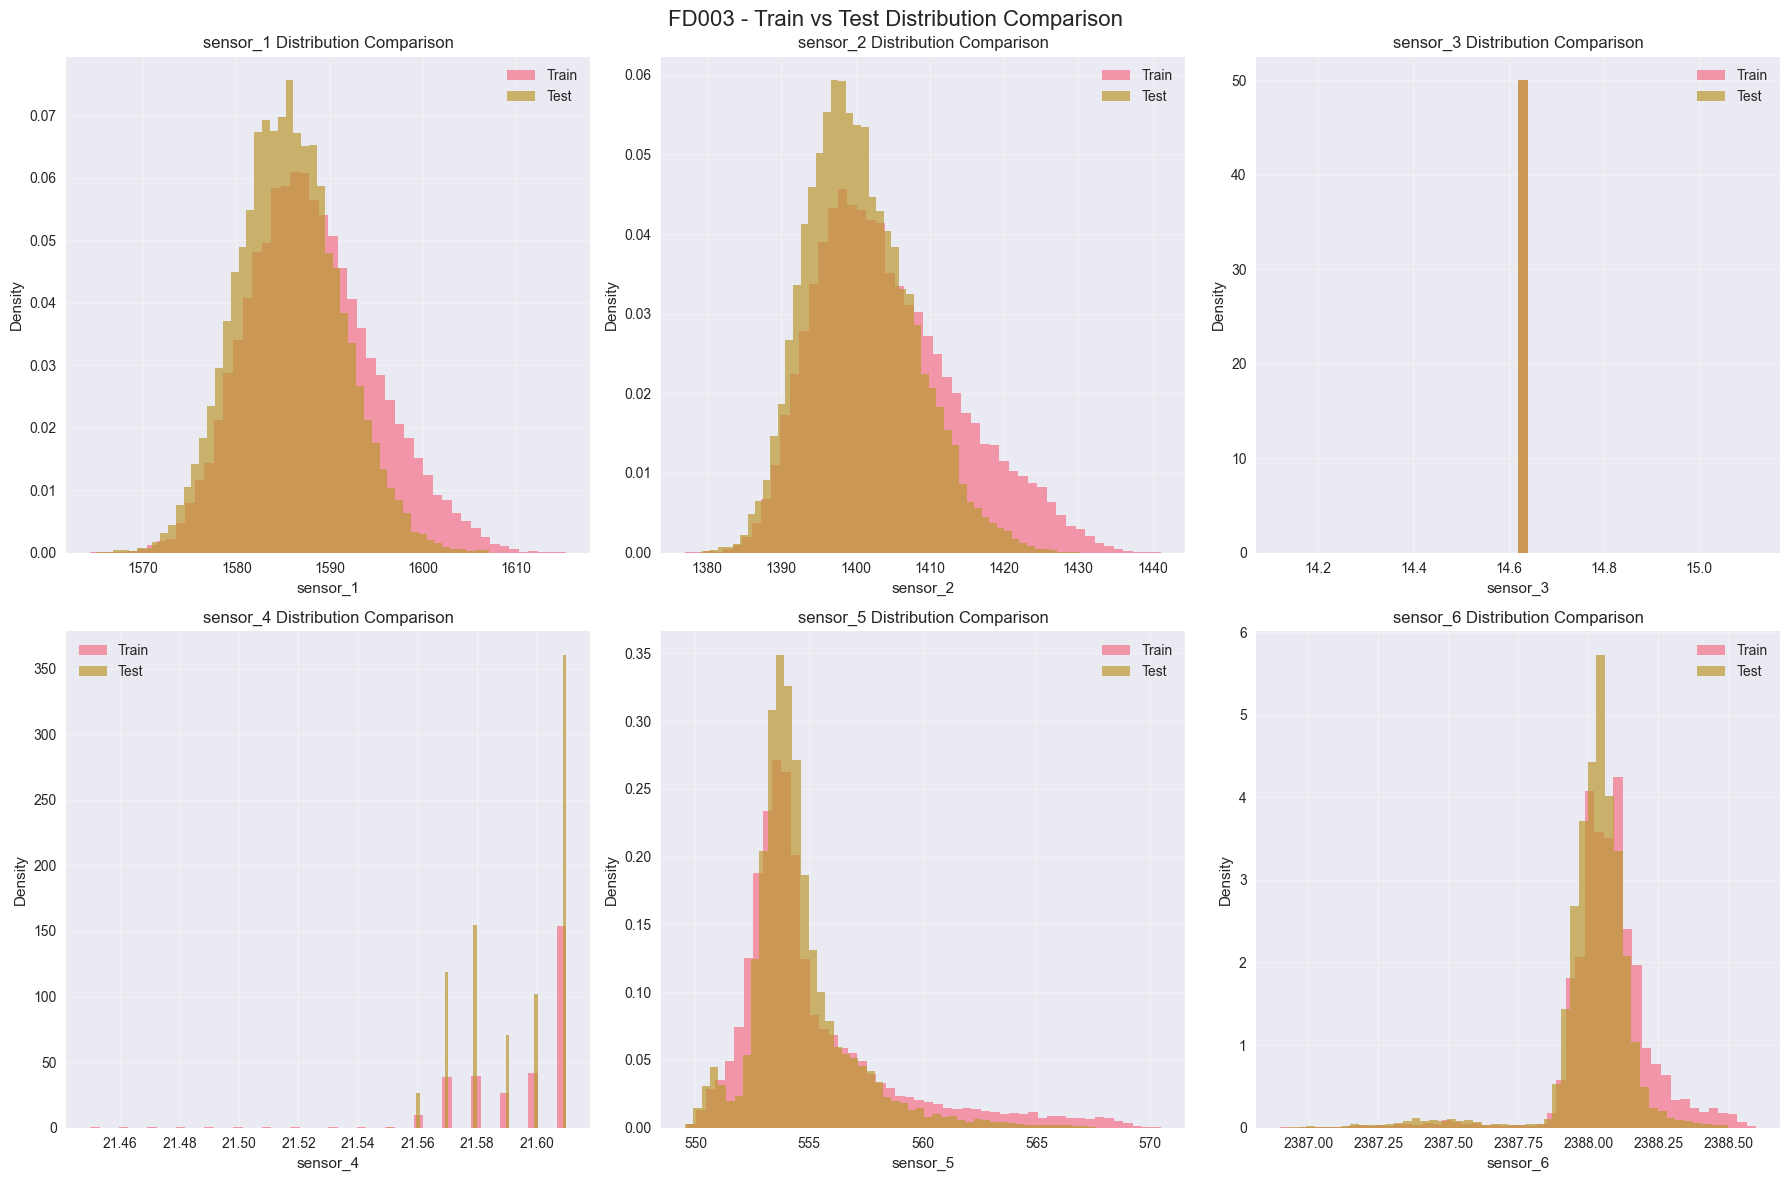

FD003 - Features with potential drift (p < 0.05):
            train_mean    test_mean ks_pvalue mw_pvalue
sensor_1   1588.079175  1585.608286       0.0       0.0
sensor_2   1404.471212  1400.567943       0.0       0.0
sensor_4     21.595841    21.594215       0.0       0.0
sensor_5    555.143808   554.555216       0.0  0.141416
sensor_6   2388.071555  2388.021318       0.0       0.0
sensor_7   9064.110809   9056.27449       0.0       0.0
sensor_8      1.301232     1.300456       0.0       0.0
sensor_9     47.415707    47.290751       0.0       0.0
sensor_10   523.050873   522.466597       0.0  0.069028
sensor_11  2388.071643  2388.021013       0.0       0.0
sensor_12  8144.202916  8138.326536       0.0       0.0
sensor_13     8.396176     8.395036       0.0       0.0
sensor_15   392.566545   391.900036       0.0       0.0
sensor_18    38.988552    38.996889       0.0  0.000022
sensor_19    23.393024    23.398909       0.0       0.0
setting3    642.457858    642.26798       0.0       0.

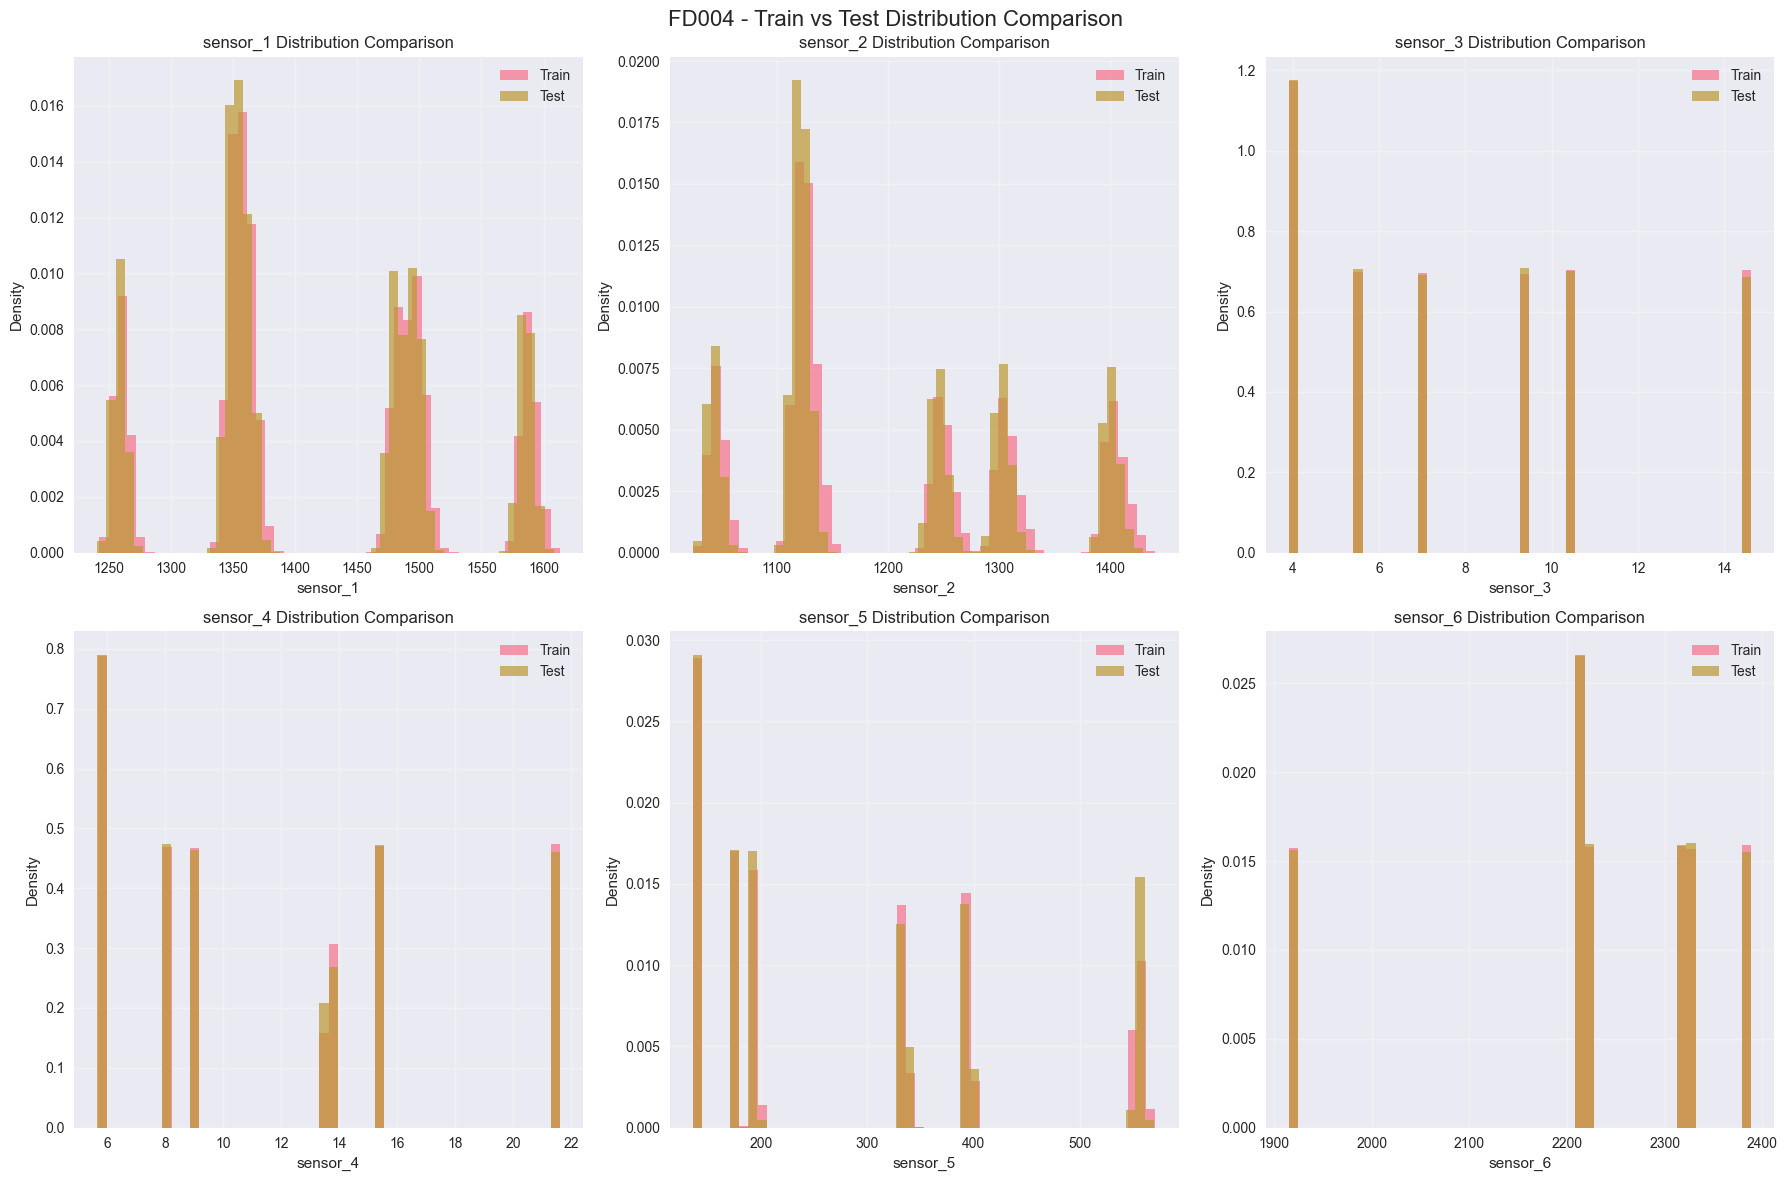

FD004 - Features with potential drift (p < 0.05):
            train_mean    test_mean ks_pvalue mw_pvalue
sensor_1     1417.8966  1414.951596       0.0       0.0
sensor_2   1201.915359  1197.321054       0.0       0.0
sensor_4     11.589457    11.544931       0.0       0.0
sensor_5    283.328633   281.946233       0.0  0.007416
sensor_6   2228.686034  2228.569346       0.0       0.0
sensor_7   8524.673301  8517.234368       0.0       0.0
sensor_8      1.096445      1.09449       0.0       0.0
sensor_9     42.874529    42.737668       0.0       0.0
sensor_10   266.735665    265.41428       0.0  0.004193
sensor_11   2334.42759  2334.733335       0.0       0.0
sensor_12  8067.811812  8063.206813       0.0       0.0
sensor_13     9.285604     9.284664       0.0  0.002376
sensor_14     0.023252     0.023029       0.0       0.0
sensor_15   347.760029   346.976319       0.0       0.0
sensor_18    20.864333    20.798613   0.00126  0.551139
sensor_19    12.518995    12.479669  0.000668  0.49530

In [14]:
# Data Drift Analysis
def analyze_data_drift(dataset_name):
    """Analyze potential data drift between train and test sets"""
    train_df = datasets[dataset_name]['train_raw']  # Use raw training data without RUL
    test_df = datasets[dataset_name]['test']

    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
    setting_cols = ['setting1', 'setting2', 'setting3']

    drift_analysis = {}

    # Statistical tests for drift detection
    for col in sensor_cols + setting_cols:
        # Kolmogorov-Smirnov test
        ks_stat, ks_pvalue = stats.ks_2samp(train_df[col], test_df[col])

        # Mann-Whitney U test
        mw_stat, mw_pvalue = stats.mannwhitneyu(train_df[col], test_df[col], alternative='two-sided')

        drift_analysis[col] = {
            'train_mean': train_df[col].mean(),
            'test_mean': test_df[col].mean(),
            'train_std': train_df[col].std(),
            'test_std': test_df[col].std(),
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pvalue,
            'mw_statistic': mw_stat,
            'mw_pvalue': mw_pvalue,
            'potential_drift': (ks_pvalue < 0.05) or (mw_pvalue < 0.05)
        }

    return pd.DataFrame(drift_analysis).T

def plot_drift_analysis(dataset_name):
    """Plot distributions to visualize potential drift"""
    train_df = datasets[dataset_name]['train_raw']
    test_df = datasets[dataset_name]['test']

    # Select a few key sensors for visualization
    sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
    key_sensors = sensor_cols[:6]  # First 6 sensors

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, sensor in enumerate(key_sensors):
        ax = axes[i]

        # Plot distributions
        ax.hist(train_df[sensor], bins=50, alpha=0.7, label='Train', density=True)
        ax.hist(test_df[sensor], bins=50, alpha=0.7, label='Test', density=True)

        ax.set_xlabel(sensor)
        ax.set_ylabel('Density')
        ax.set_title(f'{sensor} Distribution Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'{dataset_name} - Train vs Test Distribution Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_drift_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n=== DATA DRIFT ANALYSIS ===\n")
drift_results = {}
for name in dataset_names:
    drift_results[name] = analyze_data_drift(name)
    plot_drift_analysis(name)

    # Report potential drift
    potential_drift = drift_results[name][drift_results[name]['potential_drift']]
    print(f"{name} - Features with potential drift (p < 0.05):")
    if len(potential_drift) > 0:
        print(potential_drift[['train_mean', 'test_mean', 'ks_pvalue', 'mw_pvalue']].round(4))
    else:
        print("No significant drift detected")
    print()



=== ENGINE FAILURE PATTERN ANALYSIS ===



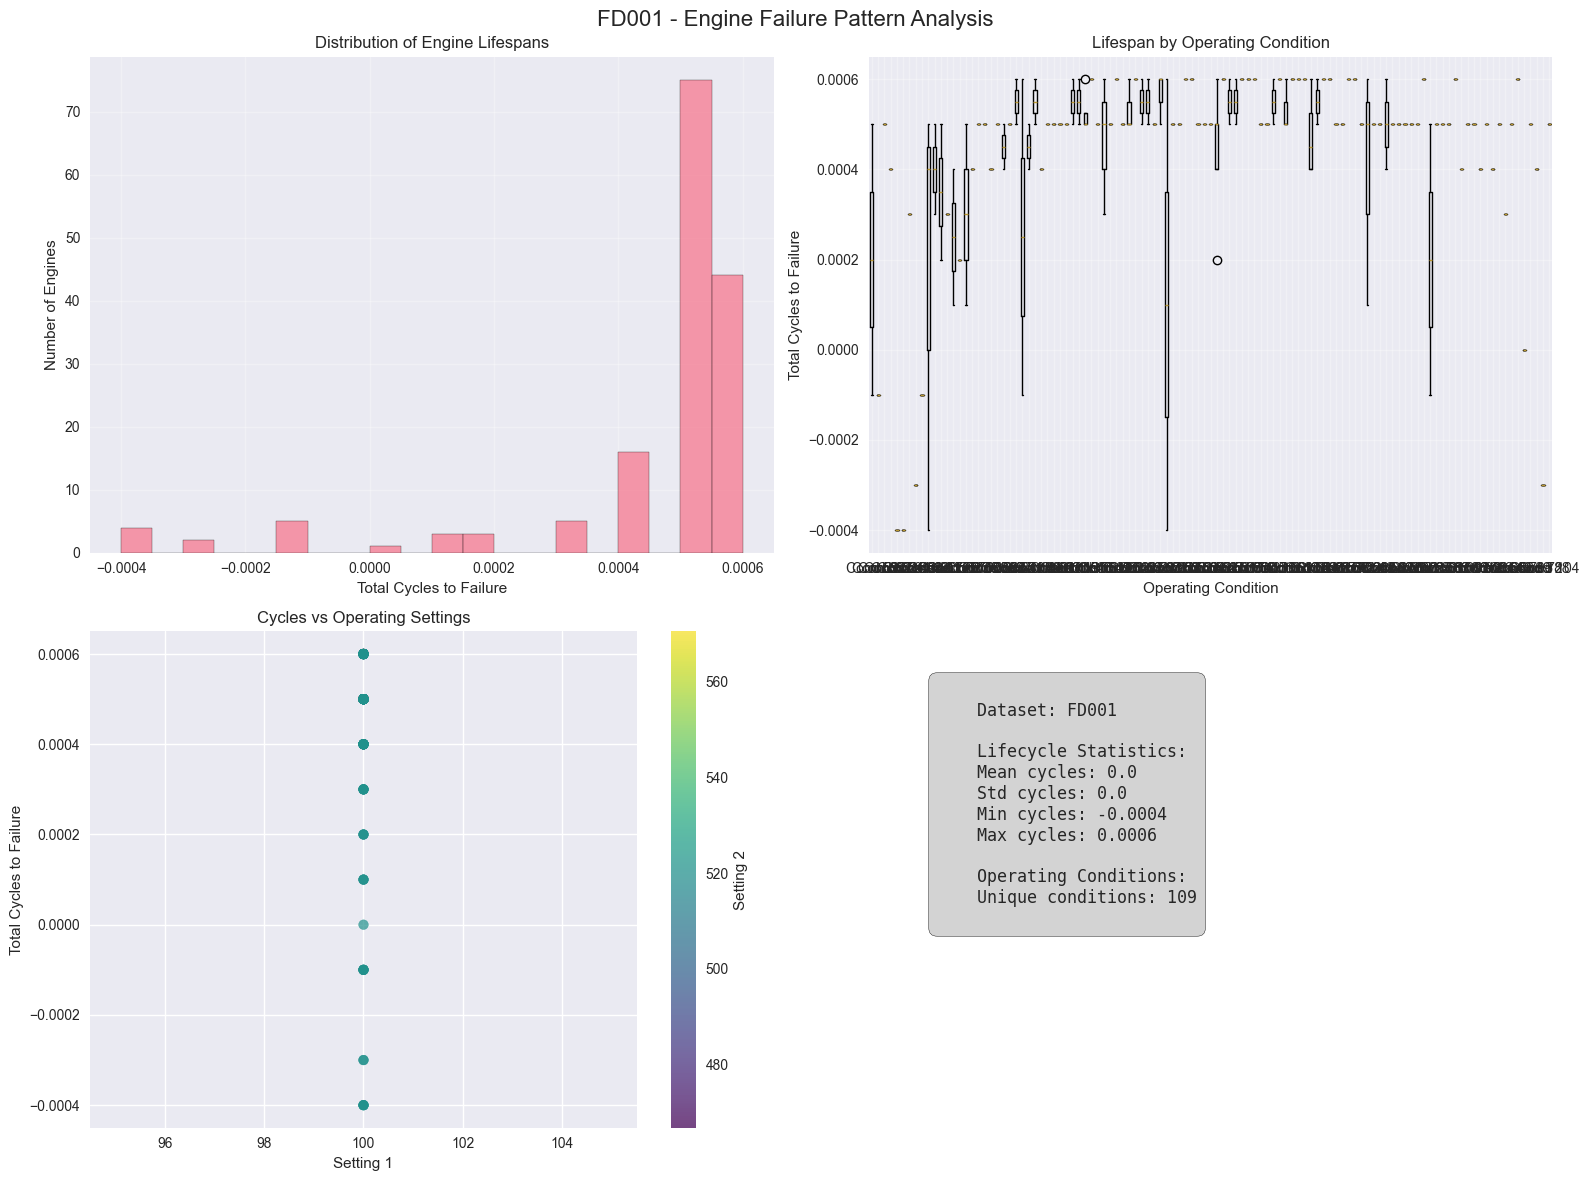

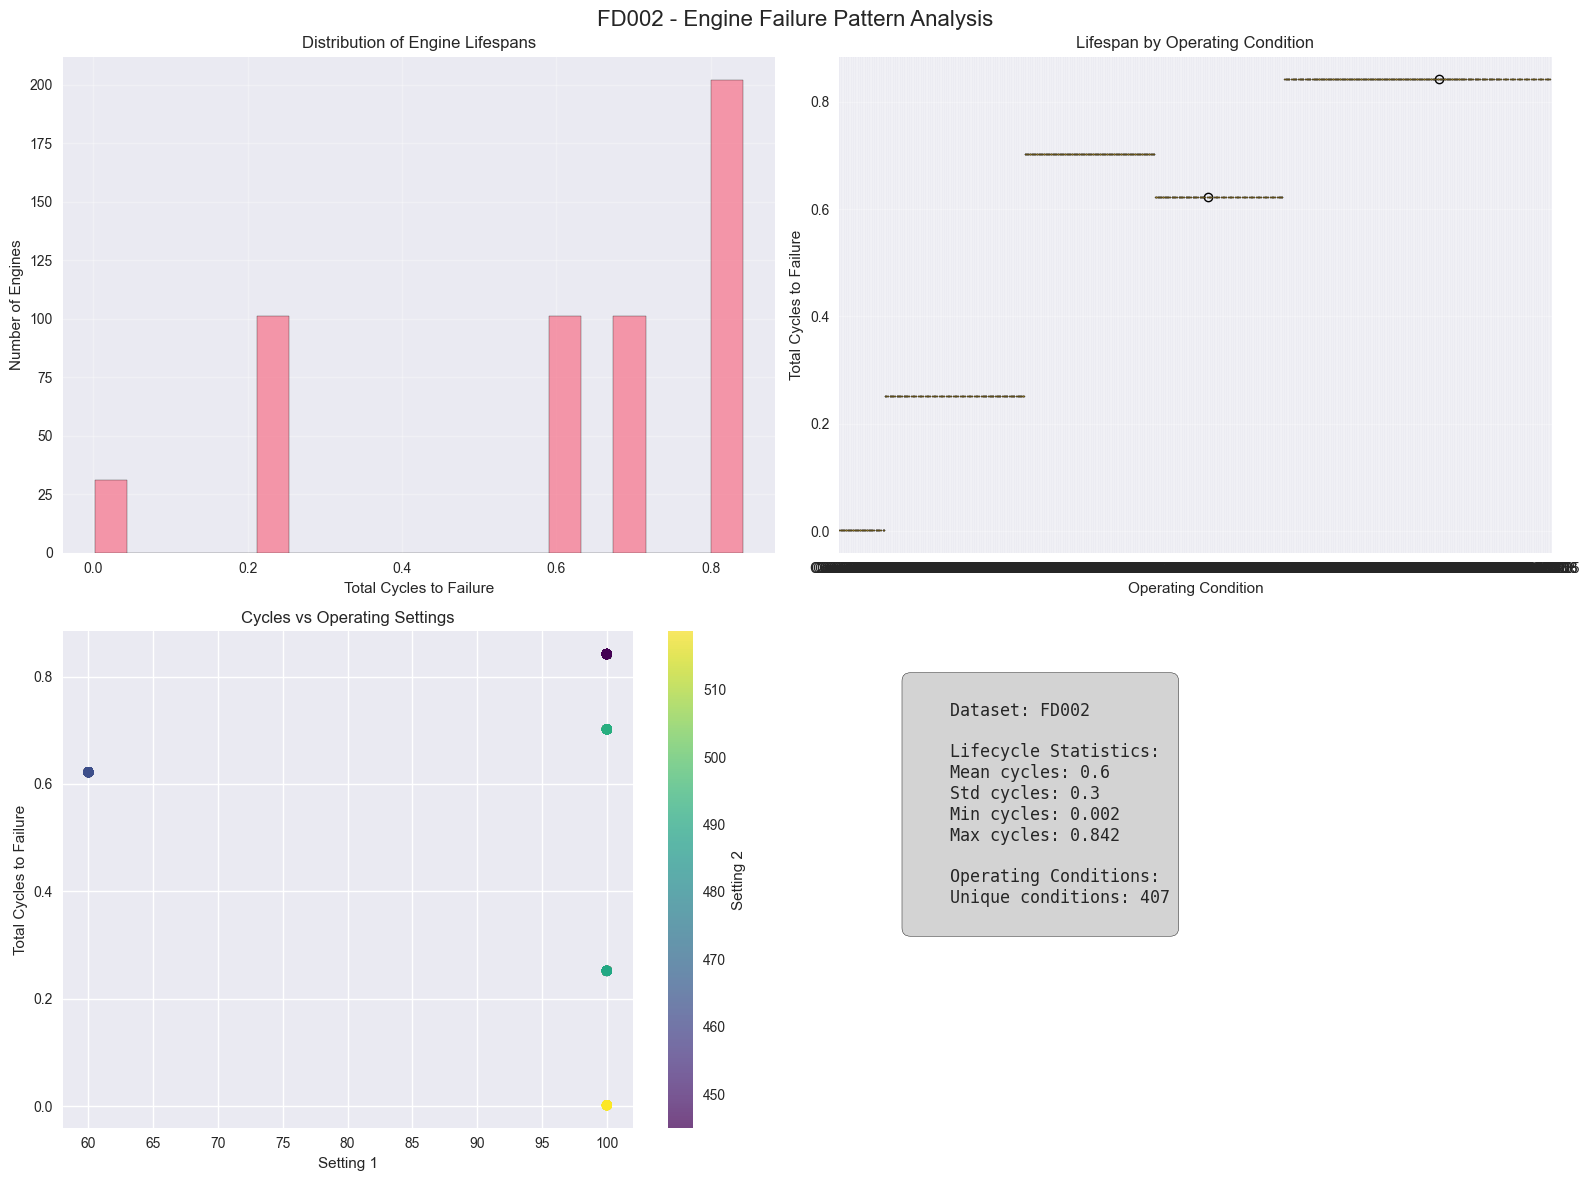

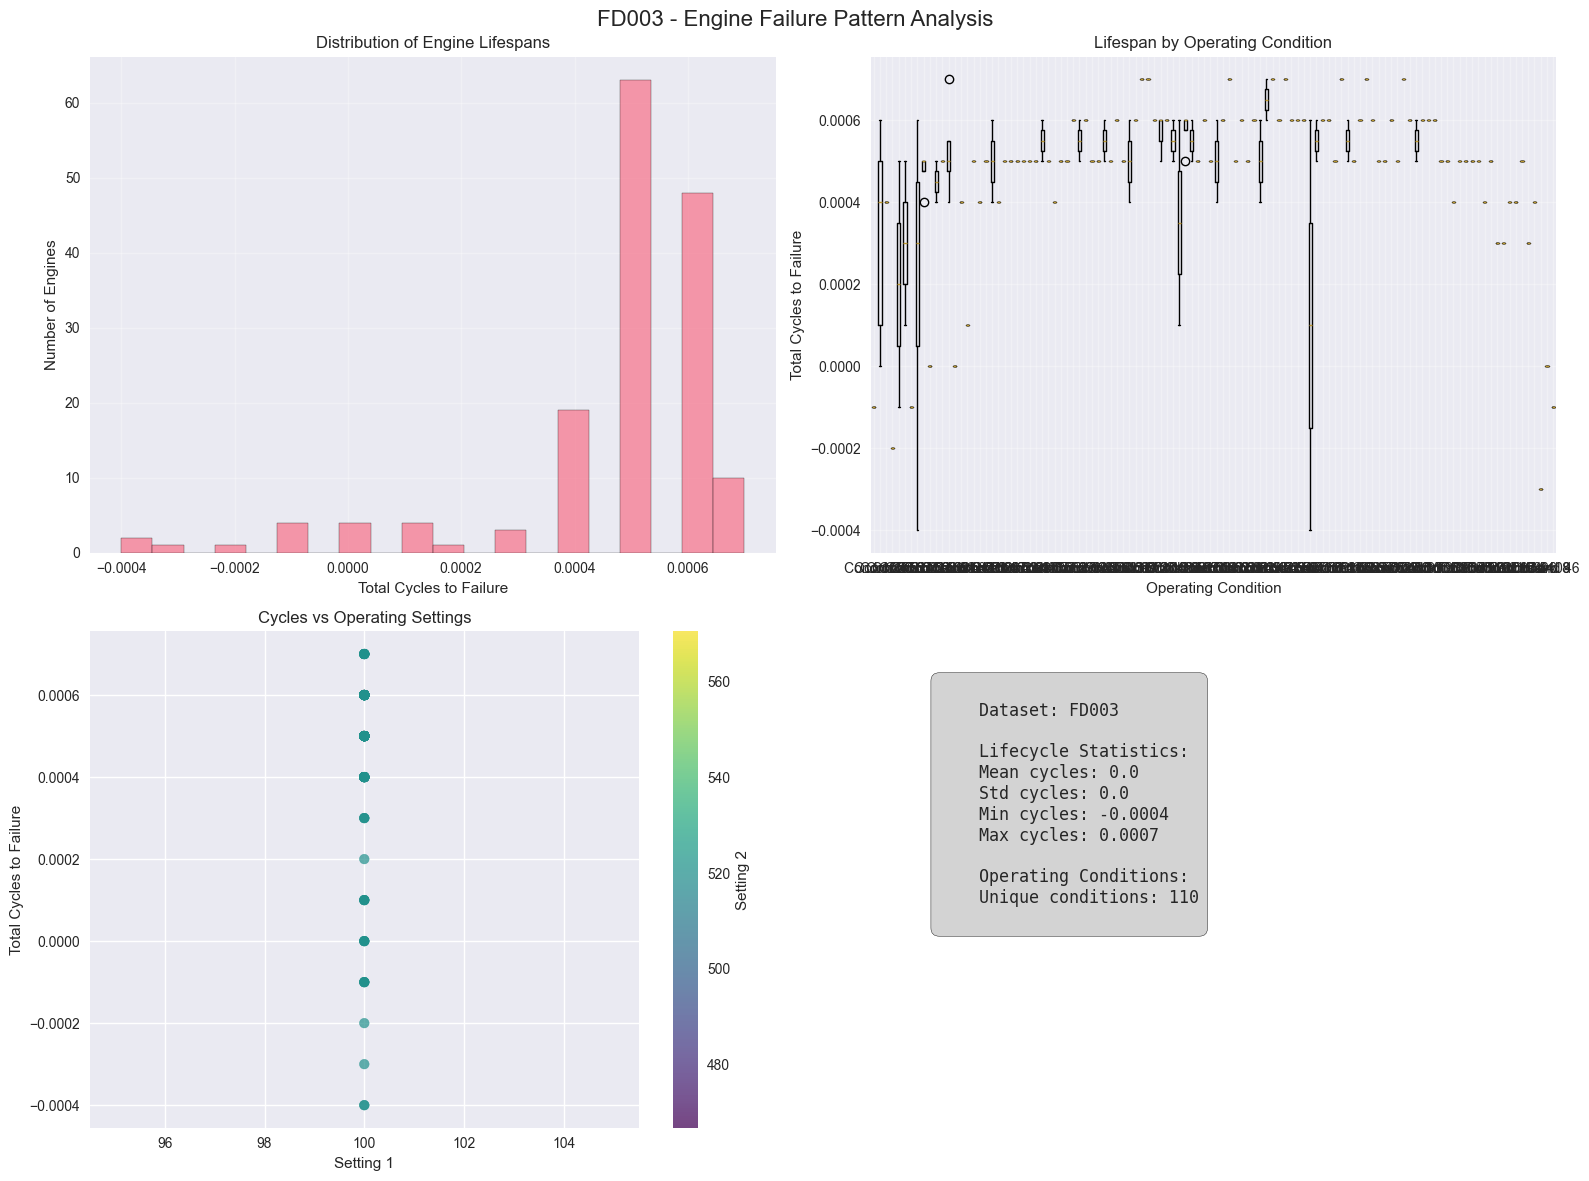

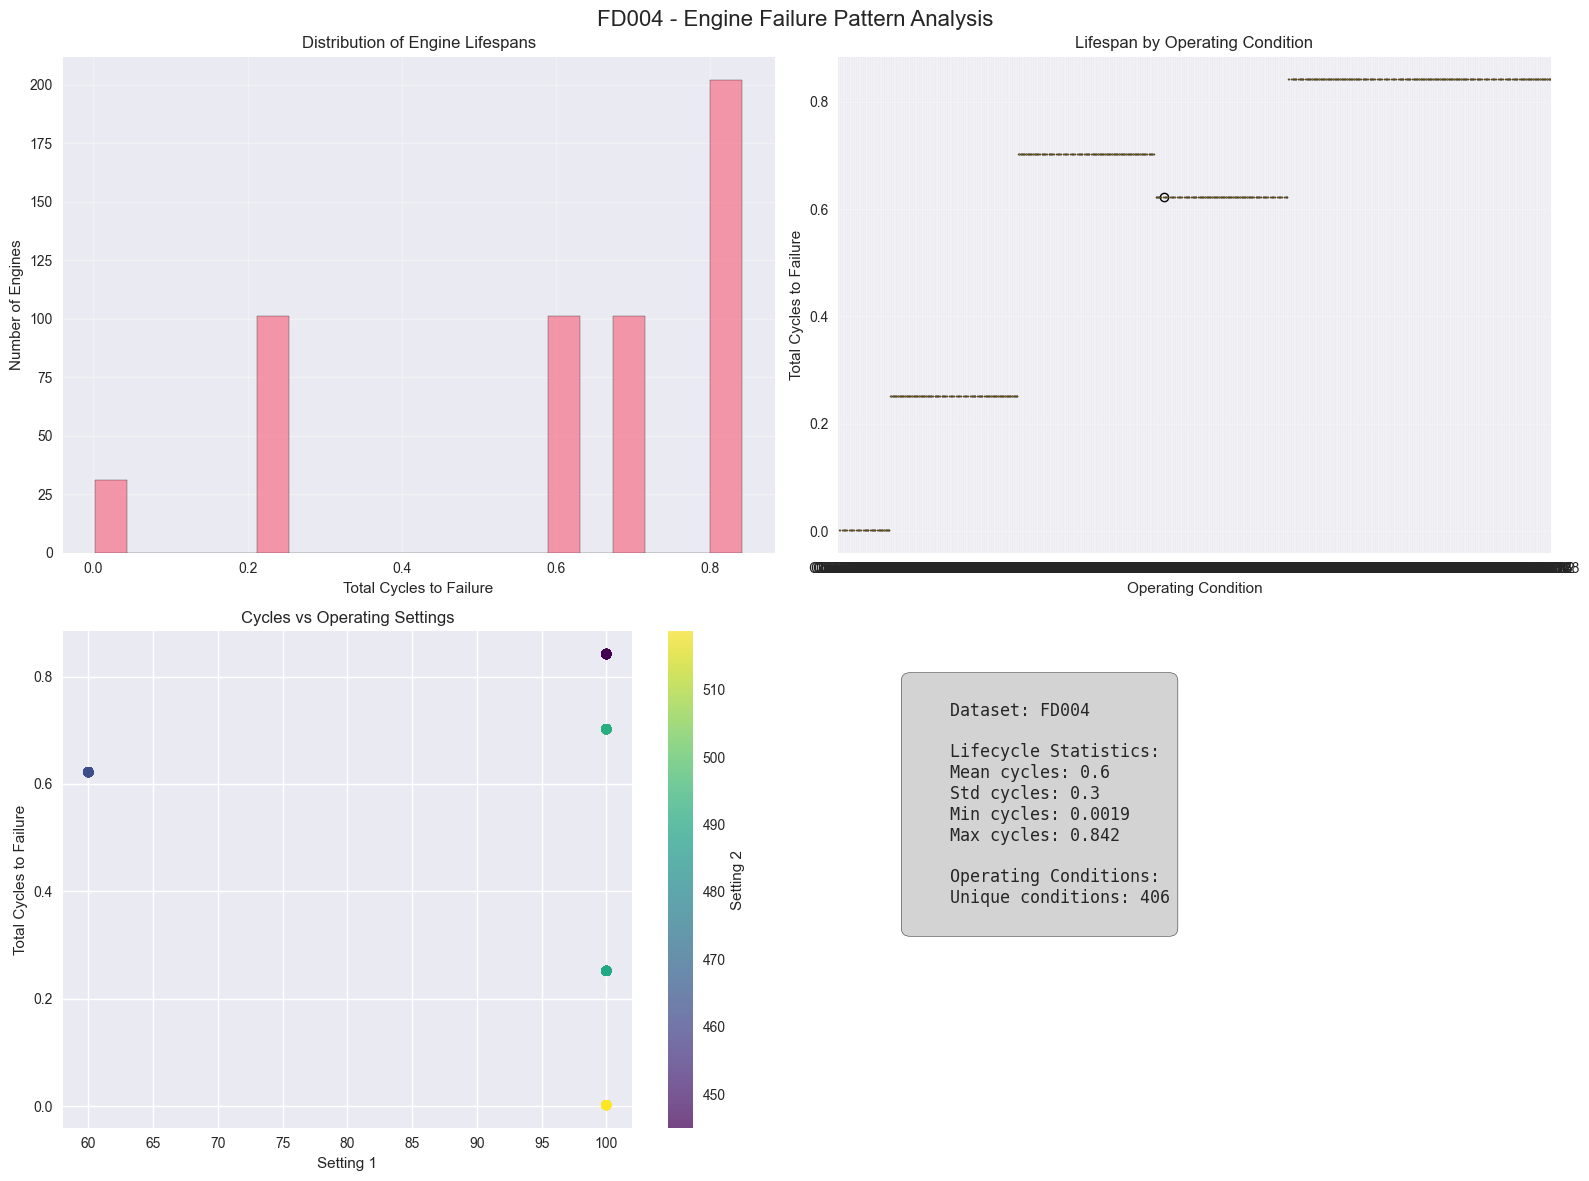

In [15]:
# Engine Failure Patterns Analysis
def analyze_failure_patterns(dataset_name):
    """Analyze patterns in engine failures and RUL distributions"""
    train_df = datasets[dataset_name]['train']

    # Engine lifecycle statistics
    engine_stats = train_df.groupby('unit_id').agg({
        'time_cycles': 'max',
        'RUL': 'min'  # Should be 0 at failure
    }).rename(columns={'time_cycles': 'total_cycles'})

    # Add operating condition information
    engine_conditions = train_df.groupby('unit_id')[['setting1', 'setting2', 'setting3']].first()
    engine_stats = engine_stats.join(engine_conditions)

    return engine_stats

def plot_failure_patterns(dataset_name):
    """Plot failure pattern analysis"""
    engine_stats = analyze_failure_patterns(dataset_name)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Total cycles distribution
    axes[0, 0].hist(engine_stats['total_cycles'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Total Cycles to Failure')
    axes[0, 0].set_ylabel('Number of Engines')
    axes[0, 0].set_title('Distribution of Engine Lifespans')
    axes[0, 0].grid(True, alpha=0.3)

    # Box plot of cycles by operating conditions (if multiple conditions exist)
    if len(engine_stats[['setting1', 'setting2', 'setting3']].drop_duplicates()) > 1:
        # Create a condition identifier
        engine_stats['condition_id'] = engine_stats.groupby(['setting1', 'setting2', 'setting3']).ngroup()

        condition_data = [engine_stats[engine_stats['condition_id'] == i]['total_cycles'].values
                         for i in engine_stats['condition_id'].unique()]

        axes[0, 1].boxplot(condition_data, labels=[f'Cond {i}' for i in engine_stats['condition_id'].unique()])
        axes[0, 1].set_xlabel('Operating Condition')
        axes[0, 1].set_ylabel('Total Cycles to Failure')
        axes[0, 1].set_title('Lifespan by Operating Condition')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'Single Operating\nCondition', ha='center', va='center',
                       transform=axes[0, 1].transAxes, fontsize=14)
        axes[0, 1].set_title('Operating Conditions')

    # Scatter plot of settings vs total cycles
    scatter = axes[1, 0].scatter(engine_stats['setting1'], engine_stats['total_cycles'],
                                c=engine_stats['setting2'], cmap='viridis', alpha=0.7)
    axes[1, 0].set_xlabel('Setting 1')
    axes[1, 0].set_ylabel('Total Cycles to Failure')
    axes[1, 0].set_title('Cycles vs Operating Settings')
    plt.colorbar(scatter, ax=axes[1, 0], label='Setting 2')

    # Statistical summary
    axes[1, 1].axis('off')
    stats_text = f"""
    Dataset: {dataset_name}

    Lifecycle Statistics:
    Mean cycles: {engine_stats['total_cycles'].mean():.1f}
    Std cycles: {engine_stats['total_cycles'].std():.1f}
    Min cycles: {engine_stats['total_cycles'].min()}
    Max cycles: {engine_stats['total_cycles'].max()}

    Operating Conditions:
    Unique conditions: {len(engine_stats[['setting1', 'setting2', 'setting3']].drop_duplicates())}
    """
    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes, fontsize=12,
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

    plt.suptitle(f'{dataset_name} - Engine Failure Pattern Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_failure_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

    return engine_stats

print("\n=== ENGINE FAILURE PATTERN ANALYSIS ===\n")
failure_patterns = {}
for name in dataset_names:
    failure_patterns[name] = plot_failure_patterns(name)



=== TEMPORAL FEATURE ANALYSIS ===



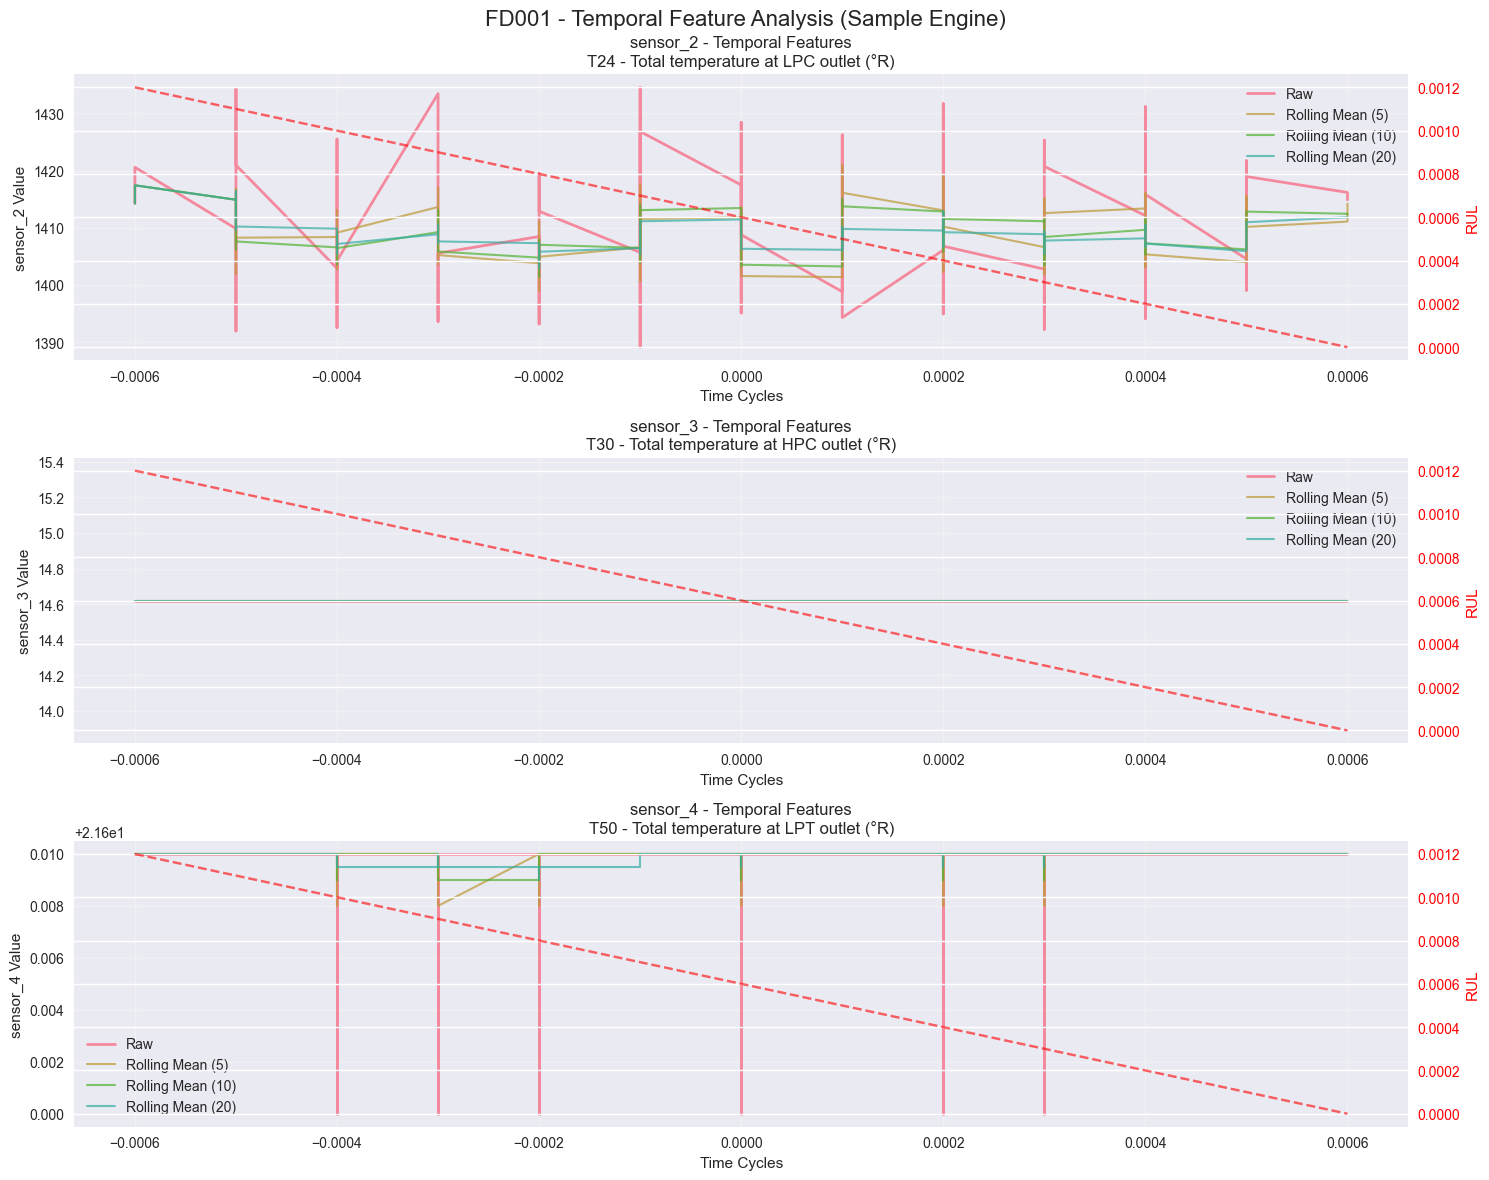

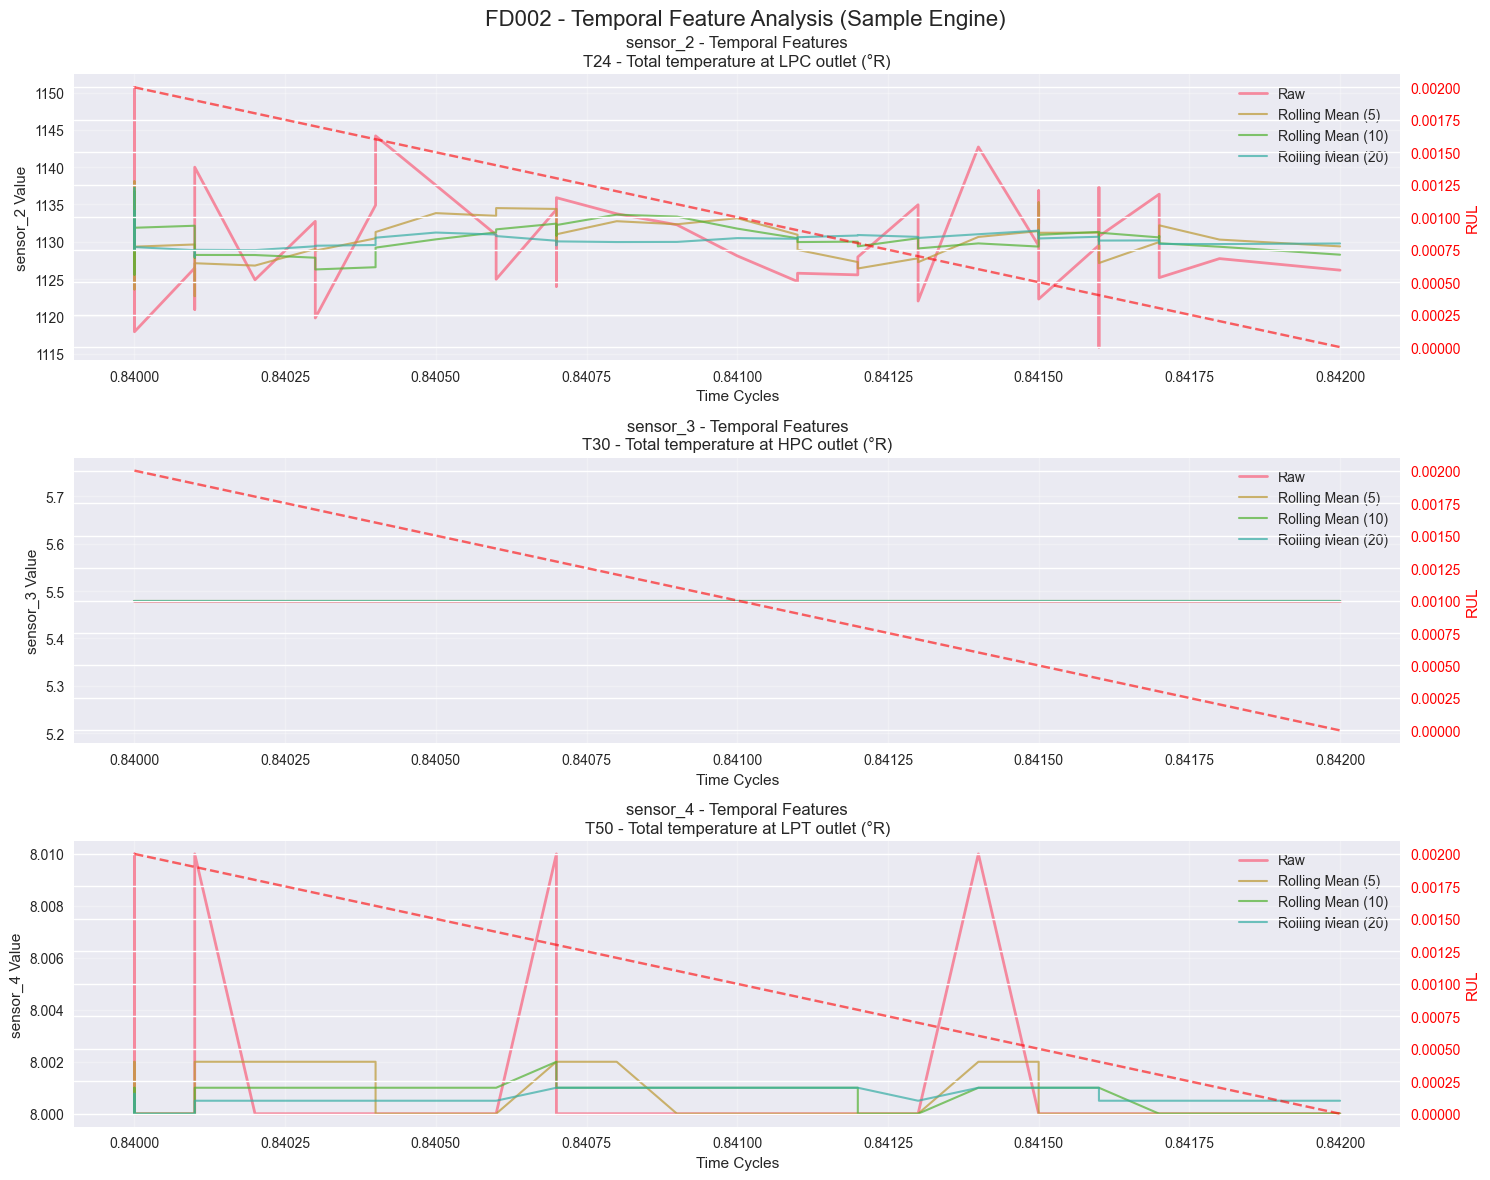

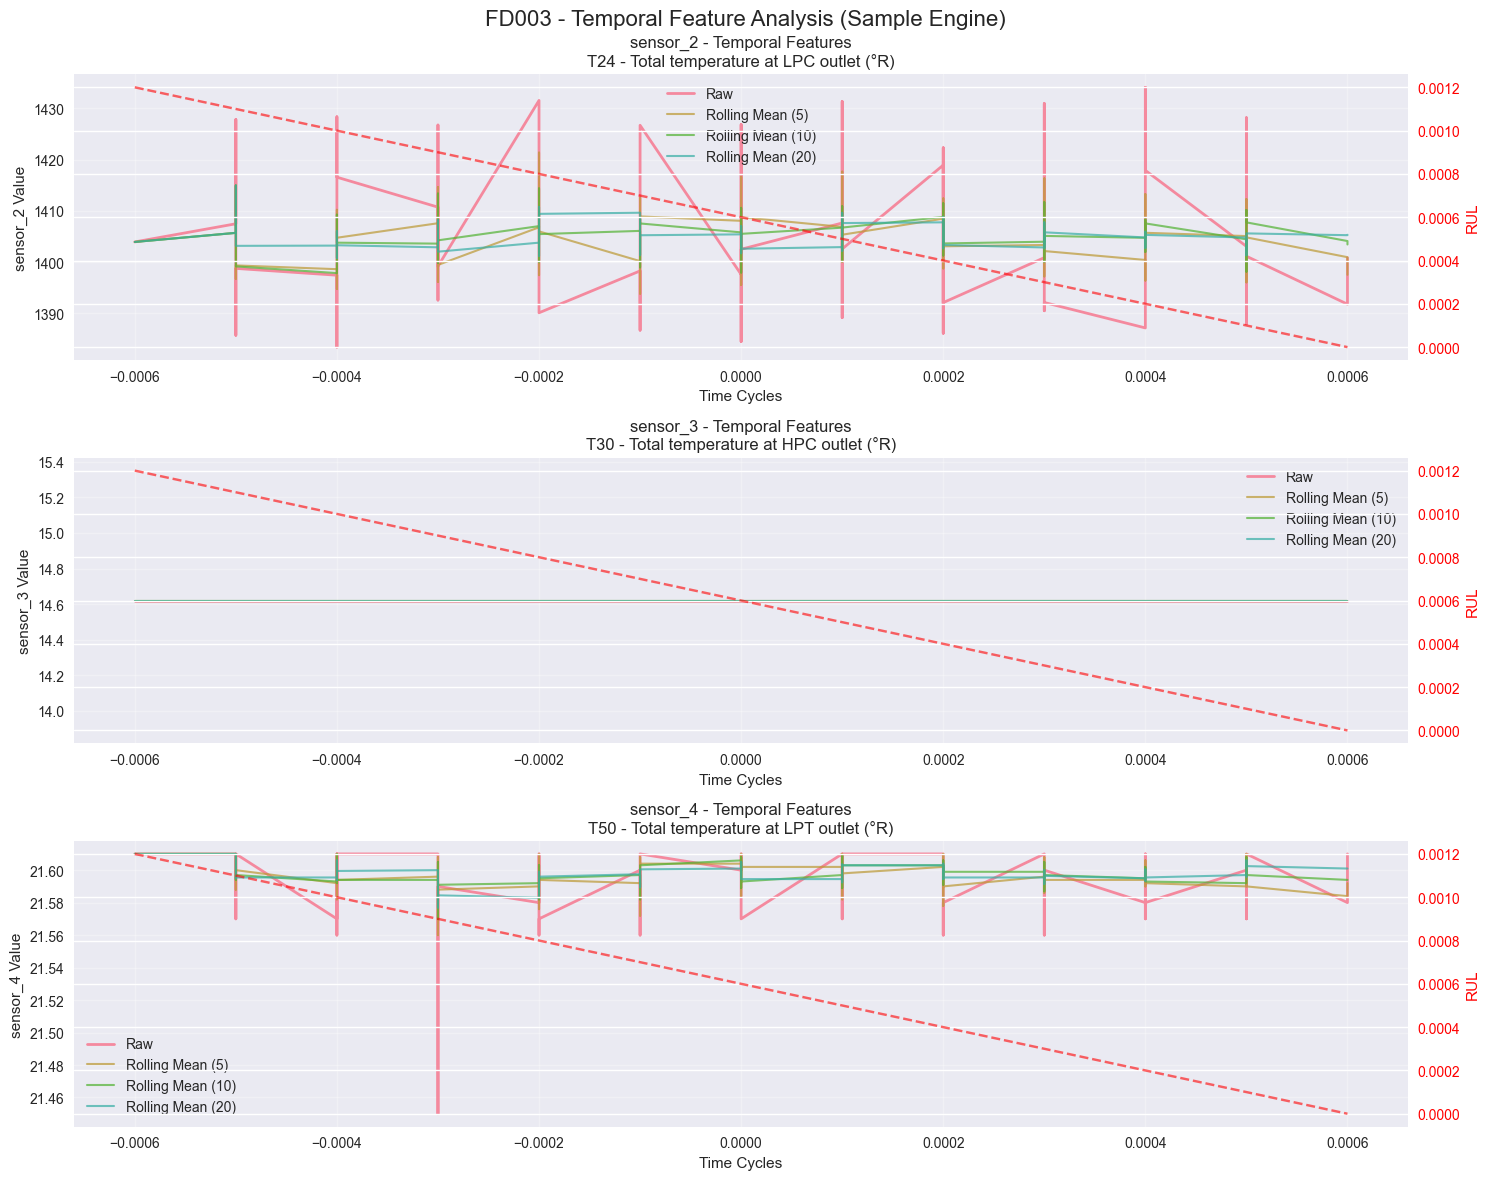

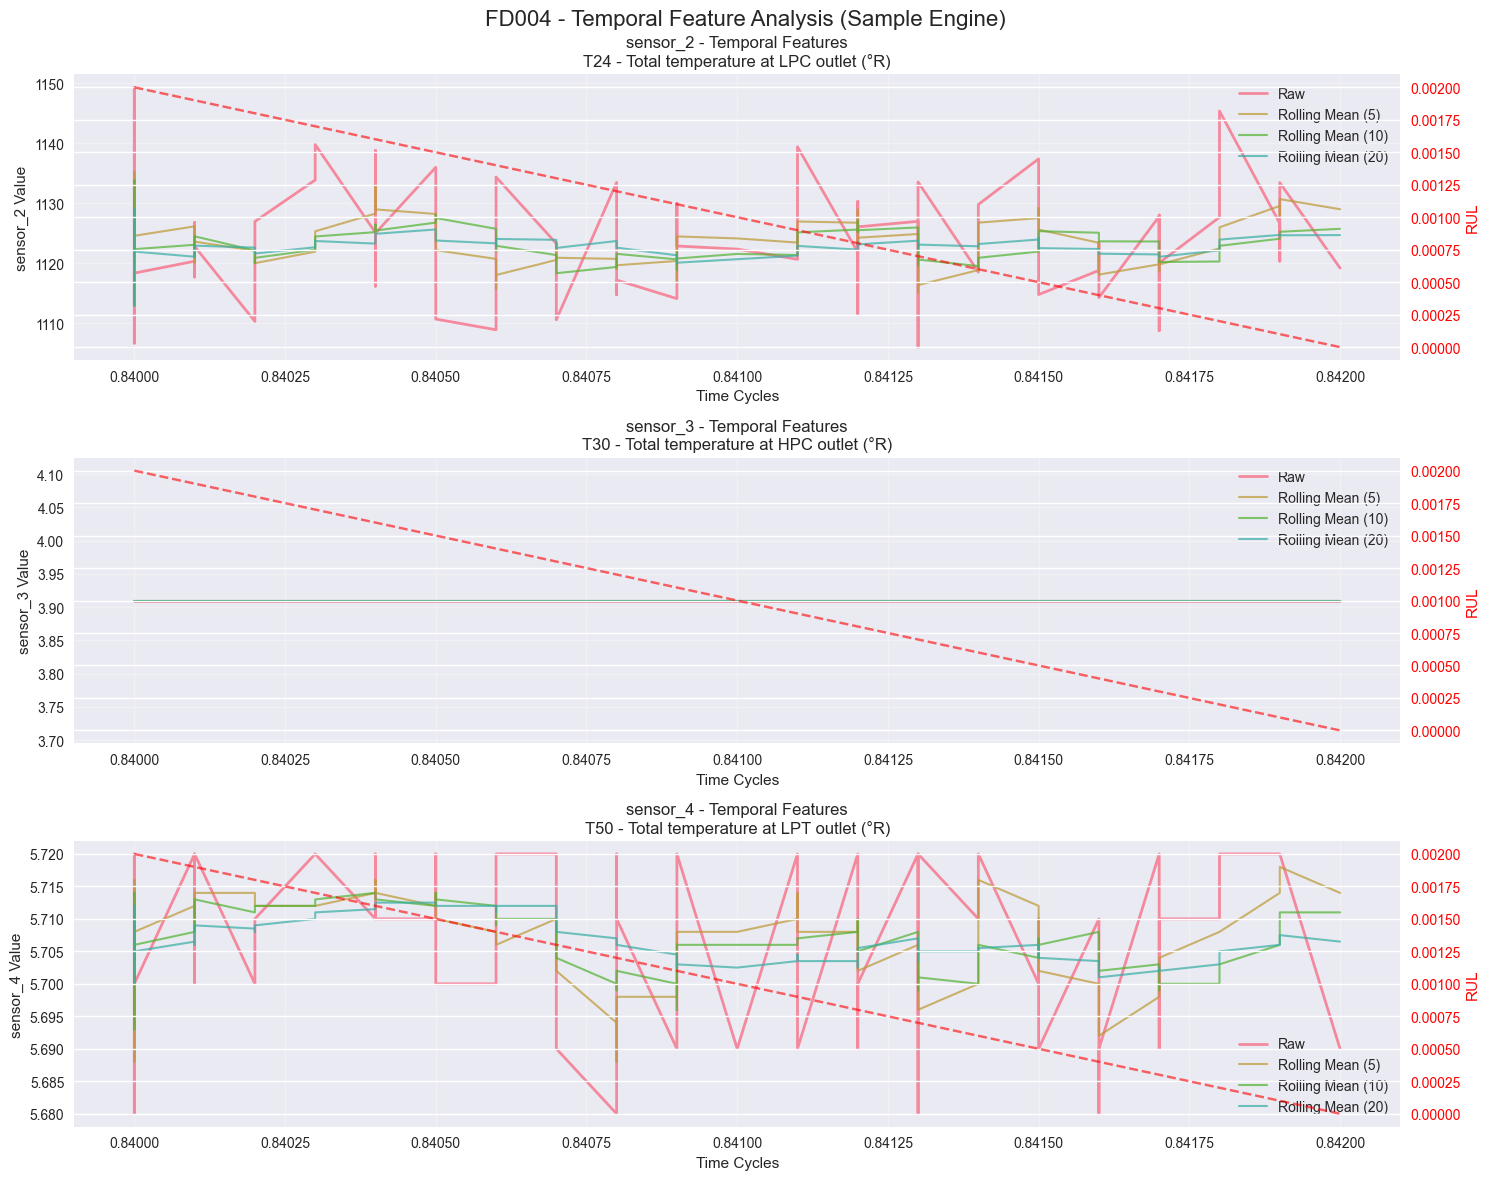

In [16]:
# Temporal Feature Engineering Insights
def analyze_temporal_features(dataset_name, window_sizes=[5, 10, 20]):
    """Analyze potential temporal features like rolling statistics"""
    train_df = datasets[dataset_name]['train']

    # Select a representative engine for demonstration
    sample_engine = train_df[train_df['unit_id'] == train_df['unit_id'].iloc[0]].copy()
    sample_engine = sample_engine.sort_values('time_cycles')

    # Select key sensors for temporal analysis
    key_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12']

    temporal_features = {}

    for sensor in key_sensors:
        sensor_features = {'raw': sample_engine[sensor].values}

        for window in window_sizes:
            # Rolling mean
            sensor_features[f'rolling_mean_{window}'] = sample_engine[sensor].rolling(window=window, min_periods=1).mean().values
            # Rolling std
            sensor_features[f'rolling_std_{window}'] = sample_engine[sensor].rolling(window=window, min_periods=1).std().values
            # Rolling trend (difference from rolling mean)
            sensor_features[f'trend_{window}'] = (sample_engine[sensor] - sample_engine[sensor].rolling(window=window, min_periods=1).mean()).values

        temporal_features[sensor] = sensor_features

    return temporal_features, sample_engine

def plot_temporal_features(dataset_name):
    """Plot temporal feature analysis"""
    temporal_features, sample_engine = analyze_temporal_features(dataset_name)

    # Plot for first 3 sensors
    sensors_to_plot = list(temporal_features.keys())[:3]

    fig, axes = plt.subplots(len(sensors_to_plot), 1, figsize=(15, 4*len(sensors_to_plot)))
    if len(sensors_to_plot) == 1:
        axes = [axes]

    for i, sensor in enumerate(sensors_to_plot):
        ax = axes[i]

        # Plot raw sensor data
        ax.plot(sample_engine['time_cycles'], temporal_features[sensor]['raw'],
                label='Raw', linewidth=2, alpha=0.8)

        # Plot rolling means
        for window in [5, 10, 20]:
            ax.plot(sample_engine['time_cycles'], temporal_features[sensor][f'rolling_mean_{window}'],
                    label=f'Rolling Mean ({window})', linewidth=1.5, alpha=0.7)

        ax.set_xlabel('Time Cycles')
        ax.set_ylabel(f'{sensor} Value')
        ax.set_title(f'{sensor} - Temporal Features\n{SENSOR_DESCRIPTIONS.get(sensor, "Unknown sensor")}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add RUL on secondary y-axis
        ax2 = ax.twinx()
        ax2.plot(sample_engine['time_cycles'], sample_engine['RUL'], 'red',
                linestyle='--', alpha=0.6, label='RUL')
        ax2.set_ylabel('RUL', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

    plt.suptitle(f'{dataset_name} - Temporal Feature Analysis (Sample Engine)', fontsize=16)
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / f'{dataset_name}_temporal_features.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze temporal features for all datasets
print("\n=== TEMPORAL FEATURE ANALYSIS ===\n")
for name in dataset_names:
    plot_temporal_features(name)


In [17]:
# Summary Report Generation
def generate_summary_report():
    """Generate comprehensive summary report of EDA findings"""

    print("="*80)
    print("NASA TURBOFAN ENGINE RUL - COMPREHENSIVE EDA SUMMARY REPORT")
    print("="*80)

    print("\n1. DATASET OVERVIEW:")
    print("-" * 40)
    for name in dataset_names:
        info = dataset_info[name]
        train_engines = datasets[name]['train']['unit_id'].nunique()
        test_engines = datasets[name]['test']['unit_id'].nunique()
        avg_life = datasets[name]['train'].groupby('unit_id')['time_cycles'].max().mean()

        print(f"{name}: {info['description']}")
        print(f"  Engines: {train_engines} train, {test_engines} test")
        print(f"  Average lifespan: {avg_life:.1f} cycles")
        print(f"  Conditions: {info['conditions']}, Fault modes: {info['fault_modes']}")
        print()

    print("\n2. KEY FINDINGS:")
    print("-" * 40)

    # Data quality summary
    print("Data Quality:")
    for name in dataset_names:
        report = quality_reports[name]
        print(f"  {name}: No missing values, {report['total_outliers']} outliers detected")

    print("\nSensor Analysis:")
    for name in dataset_names:
        low_var = sensor_analysis[name][sensor_analysis[name]['cv'] < 0.01]
        strong_indicators = trend_results[name][trend_results[name]['degradation_indicator']]
        print(f"  {name}: {len(low_var)} low-variance sensors, {len(strong_indicators)} strong degradation indicators")

    print("\nData Drift:")
    for name in dataset_names:
        drift_features = drift_results[name][drift_results[name]['potential_drift']]
        print(f"  {name}: {len(drift_features)} features show potential drift")

    print("\n3. RECOMMENDATIONS:")
    print("-" * 40)
    print("• Remove or carefully handle low-variance sensors")
    print("• Focus on sensors with strong RUL correlation for feature engineering")
    print("• Consider domain adaptation techniques for datasets with drift")
    print("• Implement temporal features (rolling statistics, trends)")
    print("• Use uncertainty quantification to handle prediction confidence")
    print("• Consider separate models for different operating conditions")

    print("\n4. NEXT STEPS:")
    print("-" * 40)
    print("• Feature engineering with temporal patterns")
    print("• Model development with uncertainty quantification")
    print("• Cross-validation strategy considering engine-level splits")
    print("• Evaluation metrics suitable for RUL prediction")

    print("\n" + "="*80)

# Generate final summary report
generate_summary_report()

NASA TURBOFAN ENGINE RUL - COMPREHENSIVE EDA SUMMARY REPORT

1. DATASET OVERVIEW:
----------------------------------------


NameError: name 'dataset_info' is not defined

In [ ]:
# Save Analysis Results
print("\n=== SAVING ANALYSIS RESULTS ===\n")

# Save key analysis results to CSV files
results_path = REPORTS_PATH / 'analysis_results'
results_path.mkdir(exist_ok=True)

for name in dataset_names:
    # Save sensor analysis
    sensor_analysis[name].to_csv(results_path / f'{name}_sensor_analysis.csv')

    # Save trend analysis
    trend_results[name].to_csv(results_path / f'{name}_trend_analysis.csv')

    # Save drift analysis
    drift_results[name].to_csv(results_path / f'{name}_drift_analysis.csv')

    # Save failure patterns
    failure_patterns[name].to_csv(results_path / f'{name}_failure_patterns.csv')

print("Analysis results saved to:", results_path)
print("\nEDA Complete! Check the reports folder for generated plots and analysis files.")
print("\nKey files generated:")
print("- Sensor correlation matrices")
print("- RUL distributions")
print("- Degradation patterns")
print("- PCA analysis")
print("- Data drift analysis")
print("- Failure pattern analysis")
print("- Temporal feature insights")
